In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, log_loss, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore', message="is_sparse is deprecated")
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s
from math import ceil
import xgboost as xgb
print(xgb.__version__)
import tqdm
import random
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay, log_loss, brier_score_loss
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

2.1.1


In [120]:
def check_metric_in_test(model, X_data, y_data):
    # Extract best parameters
    best_params = model.best_params_

    # Refit the model with the best parameters on the same training data and track log loss
    xgb_best = xgb.XGBClassifier(**best_params, n_estimators=500, objective='binary:logistic', nthread=4, early_stopping_rounds=300)

    X0_train, X0_test, y0_train, y0_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42, stratify=y_data)
    eval_set = [(X0_train, y0_train), (X0_test, y0_test)]
    
    # Fit the model
    xgb_best.fit(X0_train, y0_train, eval_set=eval_set, verbose=True)

    y0_pred_proba = xgb_best.predict_proba(X0_test)[:, 1]

    # Print metrics
    print(f"Best Parameters from Random Search: {best_params}")
    test_auc = roc_auc_score(y0_test, y0_pred_proba)
    print("Test AUC:", test_auc)

    brier_score = brier_score_loss(y0_test, y0_pred_proba)
    print("Brier score:", brier_score)

    logloss = log_loss(y0_test, y0_pred_proba)
    print("Log loss:", logloss)

    # Get the log loss values from the training process
    results = xgb_best.evals_result()

    # Plot the learning curve for train and validation log loss
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)

    plt.figure(figsize=(8, 6))
    plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
    plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss')
    plt.title('Log Loss Learning Curve (Best Model from RandomizedSearchCV)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Step 7: Plot ROC curve
    fpr, tpr, _ = roc_curve(y0_test, y0_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Step 8: Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y0_test, y0_pred_proba)
    average_precision = average_precision_score(y0_test, y0_pred_proba)

    # Step 9: Create subplots to display both curves on the same row
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax1)
    ax1.set_title(f'ROC Curve (AUC = {roc_auc:.2f})')

    # Plot Precision-Recall curve
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax2)
    ax2.set_title(f'Precision-Recall Curve (AP = {average_precision:.2f})')


    plt.tight_layout()
    plt.show()

    return y0_pred_proba

def evaluate_model(model,  X_test, y_test, model_name="Model"):
    # Print the best AUC score and corresponding hyperparameters
    print(f"### {model_name}")
    print("Best AUC Score:", model.best_score_)
    print("Best Hyperparameters:", model.best_params_)
    
    # Evaluate the model on the test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_proba)
    print("Test AUC:", test_auc)

    # Best XGBoost model from the random search
    best_xgb = model.best_estimator_

    importance = best_xgb.feature_importances_


    # Feature names
    feature_names = X_test.columns if hasattr(X_test, 'columns') else np.arange(X_test.shape[1])

    # Sorting features by importance
    sorted_idx = np.argsort(importance)

    # Creating the plot with increased font size
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(importance)), importance[sorted_idx], tick_label=np.array(feature_names)[sorted_idx])
    plt.xlabel('Feature Importance', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    plt.title('XGBoost Feature Importance', fontsize=18)

    # Increasing font size for tick labels
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Show the plot
    plt.tight_layout()
    plt.show()

def plot_calibration_curves(model, X_train, y_train, X_test, y_test, n_bins=10):
    # Predict probabilities before calibration
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate calibration curve for uncalibrated model
    prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=n_bins)
    
    # Plot calibration curve before calibration
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Before Calibration')
    plt.legend()

    # Split training data for calibration
    X_train_sub, X_calib, y_train_sub, y_calib = train_test_split(X_train, y_train, test_size=0.1, random_state=12, stratify=y_train)
    
    # Train the model on reduced training set
    model.fit(X_train_sub, y_train_sub)

    # Isotonic calibration
    calibrated_iso = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
    calibrated_iso.fit(X_calib, y_calib)
    calibrated_probs_iso = calibrated_iso.predict_proba(X_test)[:, 1]

    # Sigmoid calibration
    calibrated_sig = CalibratedClassifierCV(model, cv='prefit', method='sigmoid')
    calibrated_sig.fit(X_calib, y_calib)
    calibrated_probs_sig = calibrated_sig.predict_proba(X_test)[:, 1]

    # Plot calibrated curves
    plt.subplot(1, 2, 2)
    
    # Isotonic
    prob_true_iso, prob_pred_iso = calibration_curve(y_test, calibrated_probs_iso, n_bins=n_bins)
    plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='Isotonic calibration')

    # Sigmoid
    prob_true_sig, prob_pred_sig = calibration_curve(y_test, calibrated_probs_sig, n_bins=n_bins)
    plt.plot(prob_pred_sig, prob_true_sig, marker='o', label='Sigmoid calibration')

    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('After Calibration')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return calibrated_probs_iso, calibrated_probs_sig

def check_logreg_metrics_on_test(random_search_logreg, X_train, y_train, X_test, y_test):
    # Print the best AUC score and the corresponding hyperparameters
    print("Best AUC Score:", random_search_logreg.best_score_)
    print("Best Hyperparameters:", random_search_logreg.best_params_)

    # Get the best logistic regression model from RandomizedSearchCV
    best_logreg = random_search_logreg.best_estimator_

    # Predict probabilities for both training and test sets
    y_train_pred_prob = best_logreg.predict_proba(X_train)[:, 1]  # Probabilities for the positive class
    y_test_pred_prob = best_logreg.predict_proba(X_test)[:, 1]

    # Calculate AUC for both sets
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)

    # Calculate log loss for both sets
    train_log_loss_val = log_loss(y_train, y_train_pred_prob)
    test_log_loss_val = log_loss(y_test, y_test_pred_prob)

    # Print AUC and log loss results
    print(f"Training AUC: {train_auc:.3f}, Test AUC: {test_auc:.3f}")
    print(f"Training Log Loss: {train_log_loss_val:.3f}, Test Log Loss: {test_log_loss_val:.3f}")

    # Plot ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # ROC curve
    ax1.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.3f})")
    ax1.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {test_auc:.3f})")
    ax1.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Log loss learning curve
    train_log_losses = []
    test_log_losses = []
    train_sizes = np.linspace(0.1, 1.0, 10)

    for train_size in train_sizes:
        # Sample a portion of the training set
        X_train_partial = X_train[:int(train_size * len(X_train))]
        y_train_partial = y_train[:int(train_size * len(y_train))]

        # Fit the model on this subset of data
        best_logreg.fit(X_train_partial, y_train_partial)

        # Predict probabilities for both training and test sets
        y_train_pred_prob_partial = best_logreg.predict_proba(X_train_partial)[:, 1]
        y_test_pred_prob_partial = best_logreg.predict_proba(X_test)[:, 1]

        # Calculate log loss for both train and test sets
        train_log_losses.append(log_loss(y_train_partial, y_train_pred_prob_partial))
        test_log_losses.append(log_loss(y_test, y_test_pred_prob_partial))

    # Plot learning curve
    ax2.plot(train_sizes, train_log_losses, label='Training Log Loss')
    ax2.plot(train_sizes, test_log_losses, label='Test Log Loss')
    ax2.set_xlabel('Training Size')
    ax2.set_ylabel('Log Loss')
    ax2.set_title('Log Loss Learning Curve')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    return y_test_pred_prob

# Predicting Error Probabilities for ASE Estimation

## Overview
This notebook is dedicated to developing a model to predict error probabilities, which will serve as priors for a Bayesian model for Allele-Specific Expression (ASE) estimation. Our primary goal is to ensure that the probabilities we predict are accurate and reliable, given their crucial role in downstream Bayesian analysis. This model will focus particularly on addressing and incorporating phasing errors effectively.

## Objective
Accurately predict probabilities to be used as priors in a Bayesian model, with a particular focus on the accuracy of these probabilities in the context of phasing errors. It is vital that these probabilities are precise as they are integral to subsequent Bayesian inference steps.

In [3]:
full_data = pd.read_csv('~/data/phasing/NA12878/6finalized/exonPhasedSites_final_matrix_24828_finalized.tsv',sep='\t')
full_data["MAF"] = full_data["EUR_MAF"]
full_data["lag_MAF"] = full_data["lag_EUR_MAF"]
full_data["min_MAF"] = full_data["min_EUR_MAF"]
full_data["diff_MAF"] = full_data["diff_EUR_MAF"]
# make interaction between log10distance and r2
full_data["log10distance_intxn_r2"] = full_data["log10_distance"] * full_data["r2"]
full_data["log10distance_intxn_minMAF"] = full_data["log10_distance"] * full_data["min_MAF"]
full_data["log10distance_intxn_diffMAF"] = full_data["log10_distance"] * full_data["diff_MAF"]
full_data_sub = full_data[["chr", "pos", "geneID", "error", "d", "r2", "AF", "MAF", "lag_MAF", "min_MAF", "diff_MAF", "log10_distance","log10distance_intxn_r2","log10distance_intxn_minMAF","log10distance_intxn_diffMAF"]]

full_data_sub.head()

chr     pos           geneID  error      d     r2        AF       MAF  \
0  chr1  909419  ENSG00000187583    NaN  1.000  0.024  0.111222  0.111222   
1  chr1  914852  ENSG00000187642    NaN  0.872  0.334  0.512580  0.487420   
2  chr1  914940  ENSG00000187642    0.0  1.000  0.914  0.509585  0.490415   
3  chr1  916549  ENSG00000187642    0.0  1.000  0.503  0.758586  0.241414   
4  chr1  949608  ENSG00000187608    NaN  0.740  0.264  0.338858  0.338858   

   lag_MAF  min_MAF  diff_MAF  log10_distance  log10distance_intxn_r2  \
0      NaN      NaN       NaN             NaN                     NaN   
1   0.1839   0.1839    0.2167             NaN                     NaN   
2   0.4006   0.4006    0.0099        1.944483                1.777257   
3   0.4105   0.2416    0.1689        3.206556                1.612898   
4   0.2416   0.2416    0.1510             NaN                     NaN   

   log10distance_intxn_minMAF  log10distance_intxn_diffMAF  
0                         NaN                          NaN  
1                         NaN                          NaN  
2                    0.778960                     0.019250  
3                    0.774704                     0.541587  
4                         NaN                          NaN

In [4]:
# Define a function to process each group
def process_group(group):
    group_sorted = group.sort_values(['chr', 'pos'])
    # Check for rare SNPs
    rare_snps = group_sorted[group_sorted['MAF'] < 0.002]
    if not rare_snps.empty:
        # Calculate the ratio of the position where the rare SNP occurs
        index_of_rare_snp = rare_snps.index.min()  # Get the index of the first rare SNP
        ratio_position = (group_sorted.index.get_loc(index_of_rare_snp) + 1) / len(group_sorted)  # Calculate ratio
        return pd.Series({
            'number_of_hets': group['pos'].count(),  # Total count of positions in the gene
            'position_has_rare_SNP': ratio_position  # Ratio of the first rare SNP's position
        })

In [5]:
# Apply the function to each group
rare_df = full_data_sub.groupby('geneID').apply(process_group).dropna().reset_index()
# Print the resulting DataFrame
print(rare_df)

              geneID  number_of_hets  position_has_rare_SNP
0    ENSG00000001461             1.0               1.000000
1    ENSG00000004700             1.0               1.000000
2    ENSG00000005187             3.0               1.000000
3    ENSG00000005194             3.0               1.000000
4    ENSG00000005471             8.0               0.250000
..               ...             ...                    ...
540  ENSG00000256223             5.0               0.600000
541  ENSG00000257923            14.0               1.000000
542  ENSG00000266714            24.0               0.583333
543  ENSG00000272647             1.0               1.000000
544  ENSG00000273274             2.0               1.000000

[545 rows x 3 columns]


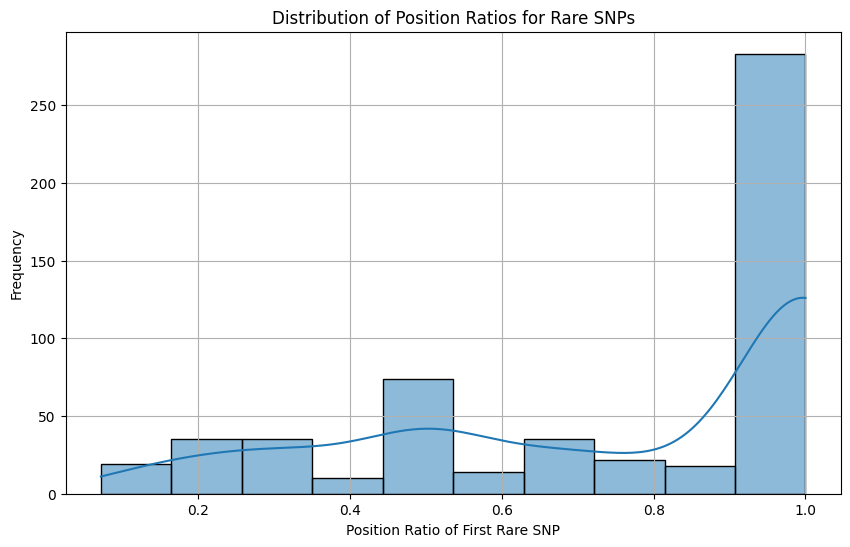

In [6]:
# Plotting the histogram of 'position_has_rare_SNP'
# Assuming 'result' is your DataFrame with the 'position_has_rare_SNP' column
position_ratios = rare_df['position_has_rare_SNP'].tolist()

plt.figure(figsize=(10, 6))
sns.histplot(position_ratios, bins=10, kde=True)
plt.title('Distribution of Position Ratios for Rare SNPs')
plt.xlabel('Position Ratio of First Rare SNP')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [7]:
# Group by 'geneID', sort within each group by 'chr' and 'pos', and drop the first entry of each group
filtered_df = full_data_sub.groupby('geneID').apply(
    lambda x: x.sort_values(['chr', 'pos']).iloc[1:]  # Remove the first row after sorting
).reset_index(drop=True)  # Reset index after filtering
filtered_df.shape
filtered_df.head()

chr        pos           geneID  error      d     r2        AF       MAF  \
0  chr1  196642533  ENSG00000000971    0.0  0.740  1.000  0.468251  0.468251   
1  chr1  196646387  ENSG00000000971    0.0  0.443  0.079  0.257188  0.257188   
2  chr1  196682947  ENSG00000000971    0.0  1.000  0.019  0.479034  0.479034   
3  chr6  143823112  ENSG00000001036    0.0  1.000  0.544  0.170128  0.170128   
4  chr6  143825104  ENSG00000001036    0.0  1.000  0.091  0.089057  0.089057   

   lag_MAF  min_MAF  diff_MAF  log10_distance  log10distance_intxn_r2  \
0   0.2604   0.2604    0.0000        2.477121                2.477121   
1   0.2604   0.2604    0.0040        3.585912                0.283287   
2   0.2644   0.2644    0.1591        4.563006                0.086697   
3   0.2247   0.2247    0.0000        3.844415                2.091362   
4   0.2247   0.2247    0.0477        3.299289                0.300235   

   log10distance_intxn_minMAF  log10distance_intxn_diffMAF  
0                    0.645042                     0.000000  
1                    0.933771                     0.014344  
2                    1.206459                     0.725974  
3                    0.863840                     0.000000  
4                    0.741350                     0.157376

In [8]:
filtered_df.head()

chr        pos           geneID  error      d     r2        AF       MAF  \
0  chr1  196642533  ENSG00000000971    0.0  0.740  1.000  0.468251  0.468251   
1  chr1  196646387  ENSG00000000971    0.0  0.443  0.079  0.257188  0.257188   
2  chr1  196682947  ENSG00000000971    0.0  1.000  0.019  0.479034  0.479034   
3  chr6  143823112  ENSG00000001036    0.0  1.000  0.544  0.170128  0.170128   
4  chr6  143825104  ENSG00000001036    0.0  1.000  0.091  0.089057  0.089057   

   lag_MAF  min_MAF  diff_MAF  log10_distance  log10distance_intxn_r2  \
0   0.2604   0.2604    0.0000        2.477121                2.477121   
1   0.2604   0.2604    0.0040        3.585912                0.283287   
2   0.2644   0.2644    0.1591        4.563006                0.086697   
3   0.2247   0.2247    0.0000        3.844415                2.091362   
4   0.2247   0.2247    0.0477        3.299289                0.300235   

   log10distance_intxn_minMAF  log10distance_intxn_diffMAF  
0                    0.645042                     0.000000  
1                    0.933771                     0.014344  
2                    1.206459                     0.725974  
3                    0.863840                     0.000000  
4                    0.741350                     0.157376

### Pre-Modeling Strategy
#### Data Preparation


In [9]:
#filtered_data = pd.read_csv('~/data/phasing/NA12878/6finalized/predict_phasing_error_data.tsv',sep='\t')
filtered_data = filtered_df
filtered_data.head()

chr        pos           geneID  error      d     r2        AF       MAF  \
0  chr1  196642533  ENSG00000000971    0.0  0.740  1.000  0.468251  0.468251   
1  chr1  196646387  ENSG00000000971    0.0  0.443  0.079  0.257188  0.257188   
2  chr1  196682947  ENSG00000000971    0.0  1.000  0.019  0.479034  0.479034   
3  chr6  143823112  ENSG00000001036    0.0  1.000  0.544  0.170128  0.170128   
4  chr6  143825104  ENSG00000001036    0.0  1.000  0.091  0.089057  0.089057   

   lag_MAF  min_MAF  diff_MAF  log10_distance  log10distance_intxn_r2  \
0   0.2604   0.2604    0.0000        2.477121                2.477121   
1   0.2604   0.2604    0.0040        3.585912                0.283287   
2   0.2644   0.2644    0.1591        4.563006                0.086697   
3   0.2247   0.2247    0.0000        3.844415                2.091362   
4   0.2247   0.2247    0.0477        3.299289                0.300235   

   log10distance_intxn_minMAF  log10distance_intxn_diffMAF  
0                    0.645042                     0.000000  
1                    0.933771                     0.014344  
2                    1.206459                     0.725974  
3                    0.863840                     0.000000  
4                    0.741350                     0.157376

In [482]:
filtered_data.shape

(17459, 12)

#### Data exploratory
**binning independent variables and calculating the average error rate**

In [10]:
def prepare_binned_data(data, variable, bins=10):
    """Bin data and calculate means for plotting."""
    data['binned'] = pd.cut(data[variable], bins=bins, labels=False)
    bin_means = data.groupby('binned')[variable].mean()
    error_means = data.groupby('binned')['error'].mean()
    return bin_means, error_means

def plot_grid(data, variables, bins=10, row_vars=4, fontsize=16):
    """Plot a grid of scatter plots for the binned data."""
    n_vars = len(variables)
    n_rows = (n_vars + row_vars - 1) // row_vars  # Calculate required number of rows
    if n_vars < row_vars:
        row_vars = n_vars  # Adjust columns if fewer variables than row_vars
    fig, axes = plt.subplots(n_rows, row_vars, figsize=(row_vars * 5, n_rows * 5), squeeze=False)
    
    for i, var in enumerate(variables):
        ax = axes[i // row_vars, i % row_vars]  # Determine the position of the subplot
        bin_means, error_means = prepare_binned_data(data, var, bins)
        
        ax.scatter(bin_means, error_means, color='blue')
        #ax.set_title(f'Mean Error Rate by {var}', fontsize=fontsize-1)
        ax.set_xlabel(var, fontsize=fontsize)
        ax.set_ylabel('Mean Error Rate', fontsize=fontsize)
        ax.grid(True)
    
    # Hide unused subplots if the number of variables is not a complete multiple of row_vars
    for j in range(i + 1, n_rows * row_vars):
        axes[j // row_vars, j % row_vars].axis('off')
    
    plt.tight_layout()
    plt.show()

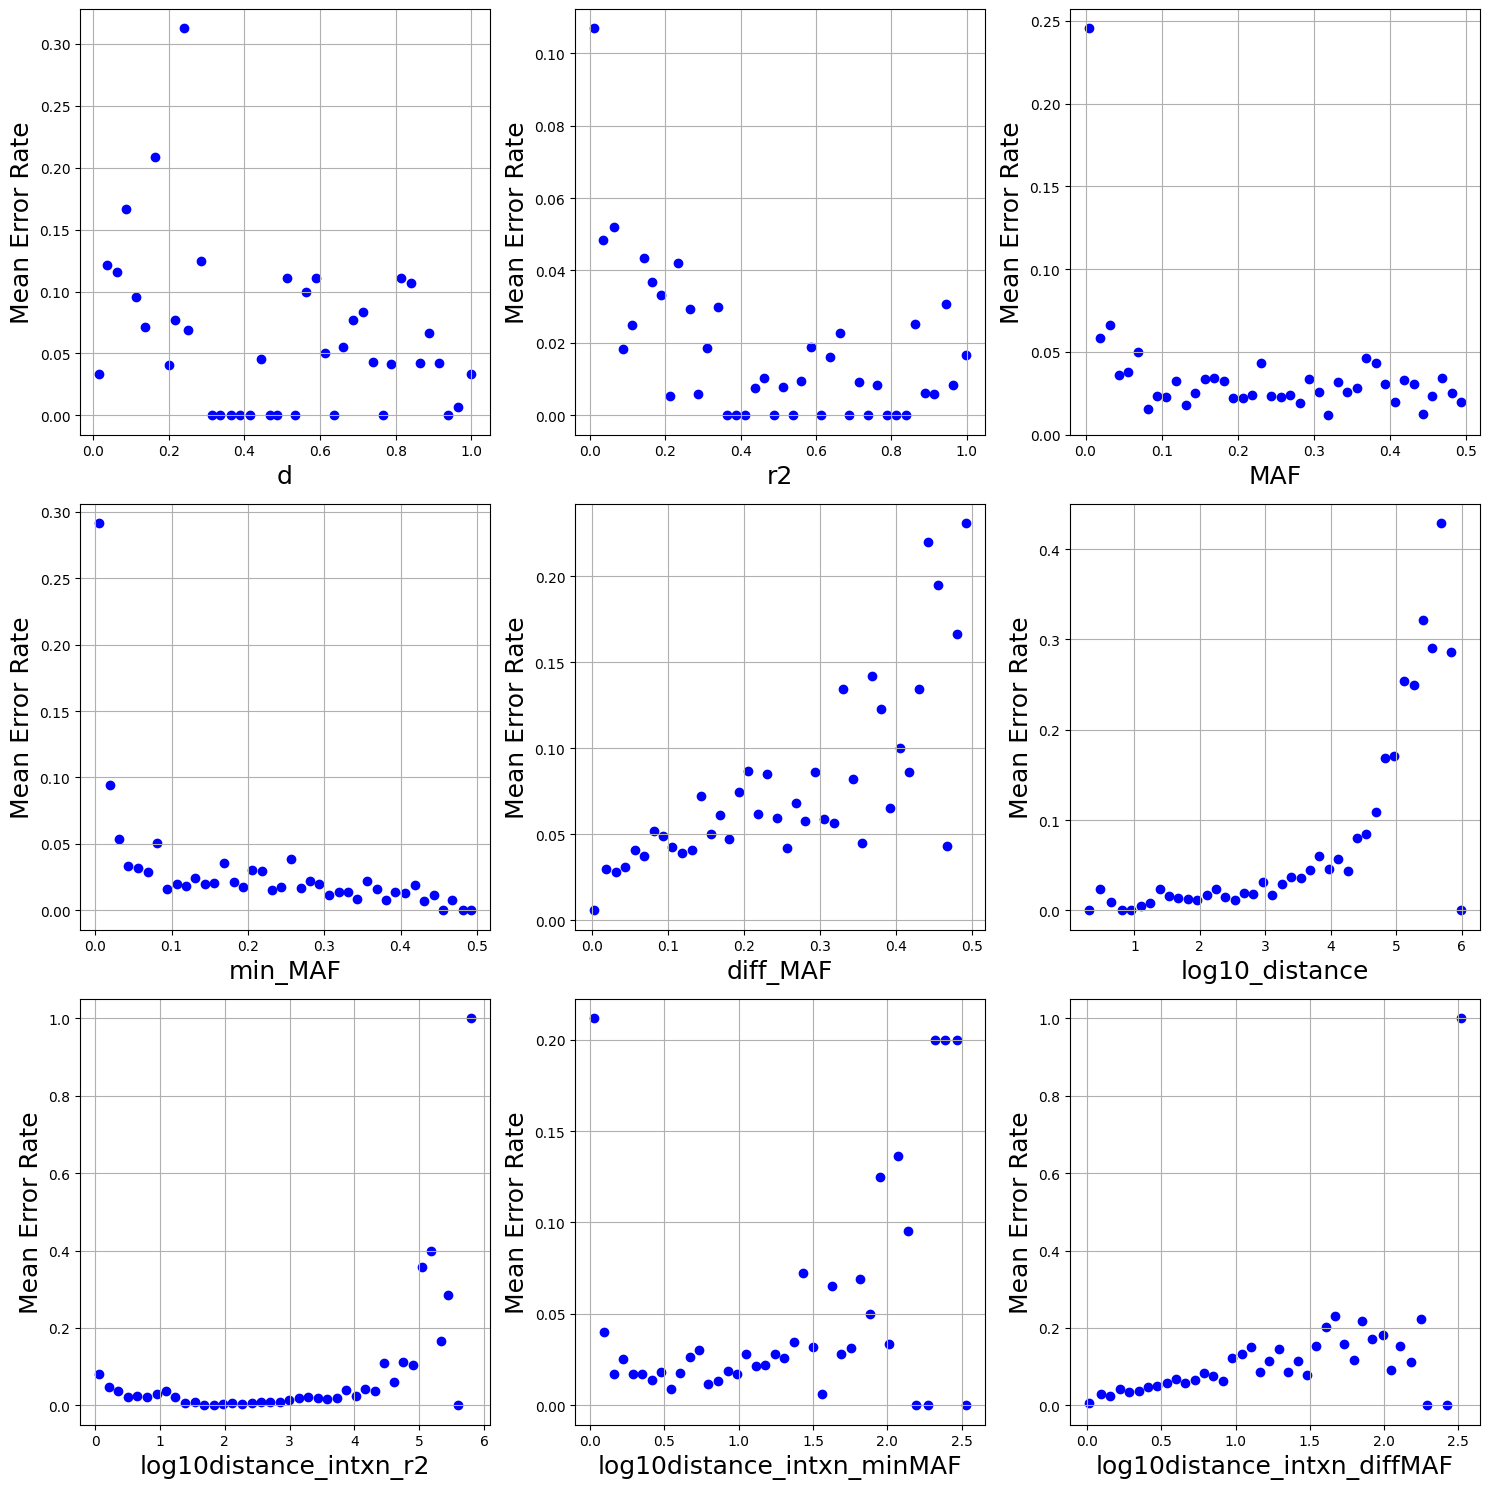

In [13]:
# List of variables to plot
variables = ['d', 'r2', 'MAF','min_MAF', 'diff_MAF', 'log10_distance','log10distance_intxn_r2', 'log10distance_intxn_minMAF','log10distance_intxn_diffMAF']

# Calling the function
plot_grid(filtered_data, variables, bins=40, row_vars=3,fontsize=18)

#### logistic regression analysis - quantitatively assesses the influence of predictors while controlling for other variables.

In [14]:

all_X = filtered_data[["log10_distance", "d", "r2", "MAF", "lag_MAF", "min_MAF", "diff_MAF","log10distance_intxn_minMAF","log10distance_intxn_r2","log10distance_intxn_diffMAF"]]  # Features dataframe
all_y = filtered_data[["error"]]    # Binary outcome

# Assuming 'X' is your DataFrame containing the features, and 'y' is the binary outcome
all_X = sm.add_constant(all_X)  # Adding a constant column to include the intercept in the model

# Model with all predictors
model_all = sm.Logit(all_y, all_X).fit()
print(model_all.summary())

Optimization terminated successfully.
         Current function value: 0.123581
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  error   No. Observations:                17459
Model:                          Logit   Df Residuals:                    17448
Method:                           MLE   Df Model:                           10
Date:                Thu, 03 Oct 2024   Pseudo R-squ.:                  0.2230
Time:                        17:52:12   Log-Likelihood:                -2157.6
converged:                       True   LL-Null:                       -2776.7
Covariance Type:            nonrobust   LLR p-value:                8.530e-260
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.6927      0.434     -3.903      0.000  

**Model decision: consider dropping EUR_MAF, lag_EUR_MAF, and AF because of NO statistical significance**

#### Drop Non-Significant Predictors to compare performance metrics AIC/BIC

In [28]:

reduced_X = filtered_data[["d", "r2", "min_MAF","log10distance_intxn_minMAF","log10distance_intxn_r2","log10distance_intxn_diffMAF"]]  # Features dataframe
reduced_y = filtered_data[["error"]]    # Binary outcome

# Assuming 'X' is your DataFrame containing the features, and 'y' is the binary outcome
reduced_X = sm.add_constant(reduced_X)  # Adding a constant column to include the intercept in the model

# Model with all predictors
model_reduced = sm.Logit(reduced_y, reduced_X).fit()
print(model_reduced.summary())

# Compare AIC and BIC
print("AIC with all variables:", model_all.aic)
print("AIC with reduced variables:", model_reduced.aic)
print("BIC with all variables:", model_all.bic)
print("BIC with reduced variables:", model_reduced.bic)

Optimization terminated successfully.
         Current function value: 0.123628
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  error   No. Observations:                17459
Model:                          Logit   Df Residuals:                    17452
Method:                           MLE   Df Model:                            6
Date:                Thu, 03 Oct 2024   Pseudo R-squ.:                  0.2227
Time:                        18:02:52   Log-Likelihood:                -2158.4
converged:                       True   LL-Null:                       -2776.7
Covariance Type:            nonrobust   LLR p-value:                6.063e-264
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.2914      0.179     -7.223      0.000  

In [30]:

reduced2_X = filtered_data[["d", "r2", "min_MAF","diff_MAF","log10_distance","log10distance_intxn_minMAF"]]  # Features dataframe
reduced2_y = filtered_data[["error"]]    # Binary outcome

# Assuming 'X' is your DataFrame containing the features, and 'y' is the binary outcome
reduced2_X = sm.add_constant(reduced2_X)  # Adding a constant column to include the intercept in the model

# Model with all predictors
model_reduced2 = sm.Logit(reduced2_y, reduced2_X).fit()
print(model_reduced2.summary())

# Compare AIC and BIC
print("AIC with all variables:", model_all.aic)
print("AIC with reduced variables:", model_reduced2.aic)
print("BIC with all variables:", model_all.bic)
print("BIC with reduced variables:", model_reduced2.bic)

Optimization terminated successfully.
         Current function value: 0.123727
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  error   No. Observations:                17459
Model:                          Logit   Df Residuals:                    17452
Method:                           MLE   Df Model:                            6
Date:                Thu, 03 Oct 2024   Pseudo R-squ.:                  0.2220
Time:                        18:07:31   Log-Likelihood:                -2160.2
converged:                       True   LL-Null:                       -2776.7
Covariance Type:            nonrobust   LLR p-value:                3.430e-263
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.8763      0.285     -6.582      0.000     

In [29]:

reduced3_X = filtered_data[["d", "r2", "min_MAF","diff_MAF","log10_distance","log10distance_intxn_r2"]]  # Features dataframe
reduced3_y = filtered_data[["error"]]    # Binary outcome

# Assuming 'X' is your DataFrame containing the features, and 'y' is the binary outcome
reduced3_X = sm.add_constant(reduced3_X)  # Adding a constant column to include the intercept in the model

# Model with all predictors
model_reduced3 = sm.Logit(reduced3_y, reduced3_X).fit()
print(model_reduced3.summary())

# Compare AIC and BIC
print("AIC with all variables:", model_all.aic)
print("AIC with reduced variables:", model_reduced3.aic)
print("BIC with all variables:", model_all.bic)
print("BIC with reduced variables:", model_reduced3.bic)

Optimization terminated successfully.
         Current function value: 0.128651
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  error   No. Observations:                17459
Model:                          Logit   Df Residuals:                    17452
Method:                           MLE   Df Model:                            6
Date:                Thu, 03 Oct 2024   Pseudo R-squ.:                  0.1911
Time:                        18:06:48   Log-Likelihood:                -2246.1
converged:                       True   LL-Null:                       -2776.7
Covariance Type:            nonrobust   LLR p-value:                5.460e-226
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3.7515      0.269    -13.949      0.000      -4.279     

**Model decision: drop EUR_MAF, lag_EUR_MAF, and AF**

##### - D, R2 values investigation

When working with variables like d and r2, which are both measures of linkage disequilibrium (LD), you need to be cautious about dropping one arbitrarily, as these variables might carry different or even complementary information about the genetic relationship between loci.

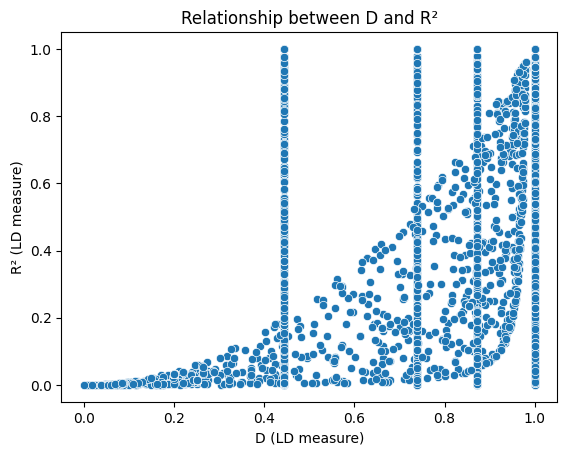

Correlation coefficient between d and r2: 0.2854921823218049
  Variable        VIF
0    const  20.602319
1        d   1.088738
2       r2   1.088738


In [55]:
# Assuming `df` is your DataFrame containing the variables
# Plotting the relationship between 'd' and 'r2'
sns.scatterplot(x='d', y='r2', data=filtered_data)
plt.xlabel('D (LD measure)')
plt.ylabel('R² (LD measure)')
plt.title('Relationship between D and R²')
plt.show()

# Calculating the correlation coefficient
correlation = filtered_data['d'].corr(filtered_data['r2'])
print("Correlation coefficient between d and r2:", correlation)

# Checking for multicollinearity
# Add a constant for the intercept
df_vif = add_constant(filtered_data[['d', 'r2']])  # include other model features if necessary
vif_data = pd.DataFrame()
vif_data["Variable"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
print(vif_data)


Weak Linear Relationship: The correlation coefficient and the scatter plot both suggest that while there is a form of relationship between D and R², it is not strongly linear. This means using one as a proxy for the other in predictive modeling could lead to loss of information.

Low Multicollinearity: The low VIF values suggest that keeping both D and R² in the same regression model should not introduce significant multicollinearity issues. This allows for both variables to be used together without concerns of inflating the variance of the estimated coefficients.

Model Inclusion Decision:

Keep Both Variables: Given their unique contributions and low multicollinearity, you may consider keeping both D and R² in your model to capture different aspects of LD.
Investigate Further: The distinct vertical bands in the plot suggest that R²'s behavior with respect to D could be segmented or conditional. Further investigation into the nature of these bands might provide insights into biological or methodological reasons behind this pattern.

**Model decision: we are keeping D**

### Modeling
#### XGBoost

In [31]:
filtered_data.head()
filtered_data=filtered_df

In [32]:
filtered_data

chr        pos           geneID  error      d     r2        AF  \
0       chr1  196642533  ENSG00000000971    0.0  0.740  1.000  0.468251   
1       chr1  196646387  ENSG00000000971    0.0  0.443  0.079  0.257188   
2       chr1  196682947  ENSG00000000971    0.0  1.000  0.019  0.479034   
3       chr6  143823112  ENSG00000001036    0.0  1.000  0.544  0.170128   
4       chr6  143825104  ENSG00000001036    0.0  1.000  0.091  0.089057   
...      ...        ...              ...    ...    ...    ...       ...   
17454  chr12   14019157  ENSG00000273079    0.0  1.000  0.042  0.037939   
17455   chr1   32961534  ENSG00000273274    0.0  1.000  0.091  0.001997   
17456   chr7  130623257  ENSG00000273319    0.0  1.000  0.539  0.835663   
17457   chr7  130623437  ENSG00000273319    0.0  1.000  0.605  0.942492   
17458   chr7  130623889  ENSG00000273319    0.0  1.000  1.000  0.836861   

            MAF  lag_MAF  min_MAF  diff_MAF  log10_distance  \
0      0.468251   0.2604   0.2604    0.0000        2.477121   
1      0.257188   0.2604   0.2604    0.0040        3.585912   
2      0.479034   0.2644   0.2644    0.1591        4.563006   
3      0.170128   0.2247   0.2247    0.0000        3.844415   
4      0.089057   0.2247   0.2247    0.0477        3.299289   
...         ...      ...      ...       ...             ...   
17454  0.037939   0.1829   0.1163    0.0666        5.497162   
17455  0.001997   0.0795   0.0089    0.0706        3.484442   
17456  0.164337   0.2097   0.1571    0.0526        2.840733   
17457  0.057508   0.1571   0.0974    0.0597        2.255272   
17458  0.163139   0.0974   0.0974    0.0597        2.655138   

       log10distance_intxn_r2  log10distance_intxn_minMAF  \
0                    2.477121                    0.645042   
1                    0.283287                    0.933771   
2                    0.086697                    1.206459   
3                    2.091362                    0.863840   
4                    0.300235                    0.741350   
...                       ...                         ...   
17454                0.230881                    0.639320   
17455                0.317084                    0.031012   
17456                1.531155                    0.446279   
17457                1.364440                    0.219664   
17458                2.655138                    0.258610   

       log10distance_intxn_diffMAF  binned  
0                         0.000000       0  
1                         0.014344       0  
2                         0.725974      11  
3                         0.000000       0  
4                         0.157376       2  
...                            ...     ...  
17454                     0.366111       5  
17455                     0.246002       3  
17456                     0.149423       2  
17457                     0.134640       2  
17458                     0.158512       2  

[17459 rows x 16 columns]

# Model comparisonn

## XGBoost

In [36]:
# Define Stratified K-Fold cross-validator
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)

#### Cross-Validation for Model Selection and Evaluation - XGBoost

In [99]:
params = {
    'lambda': [0.5, 1, 2, 3, 5],  # Narrowing down around 1
    'alpha': [3, 5, 7, 10],  # Narrowing down around 5
    'gamma': [0, 0.5, 1, 2],  # Finer granularity around 0
    'max_depth': [2, 3, 4, 5],  # Tighter range around 2
    'min_child_weight': [0.5, 1, 2],  # Tighter around 1
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.8],  # Narrowing around 0.4
    'colsample_bytree': [0.4, 0.6, 0.8, 1],  # Slight variation around 1
    'max_delta_step': [3, 4, 5, 6, 8],  # Fine-tuning around 5
}
# Define the model
estimator = XGBClassifier(
    learning_rate=0.1,
    n_estimators=500,
    objective='binary:logistic',
    eval_metric='logloss',
    nthread=4
)
# Number of folds for cross-validation and number of parameter combinations
param_comb = 250

# Randomized search for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(
    estimator=estimator, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    cv=skf,     # Pass StratifiedKFold object directly
    n_jobs=1,
    verbose=3, 
    random_state=1001
)

### XGBoot Model1

In [102]:
# Step 2: Split data into training and test sets with a fixed random seed
# Assuming 'df' is your dataframe, 'target' is the binary outcome column, and 'features' is a list of feature columns
X1 = filtered_data[["d", "r2","min_MAF", "log10distance_intxn_minMAF","log10distance_intxn_r2","log10distance_intxn_diffMAF"]]  # Features dataframe
y = filtered_data[["error"]]    # Binary outcome

# Split the dataset with stratification based on the target to maintain the proportion of classes
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.25, random_state=42, stratify=y)

In [103]:
random_search_xgb1 = random_search_xgb.fit(X1_train, y1_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.875 total time=   0.1s
[CV 2/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.900 total time=   0.1s
[CV 3/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.866 total time=   0.1s
[CV 4/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.906 total time=   0.1s
[CV 5/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.877 total time=   0.1s
[CV 1/5] END alpha=7, colsample_bytree=0.4, gamma=1, lambda=3, max_delta_step=6, max_depth=3, min_child_we

### Model1
Best AUC Score: 0.8898142187016036
Best Hyperparameters: {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 2, 'max_delta_step': 5, 'lambda': 2, 'gamma': 0.5, 'colsample_bytree': 1, 'alpha': 5}
Test AUC: 0.8953237284027764


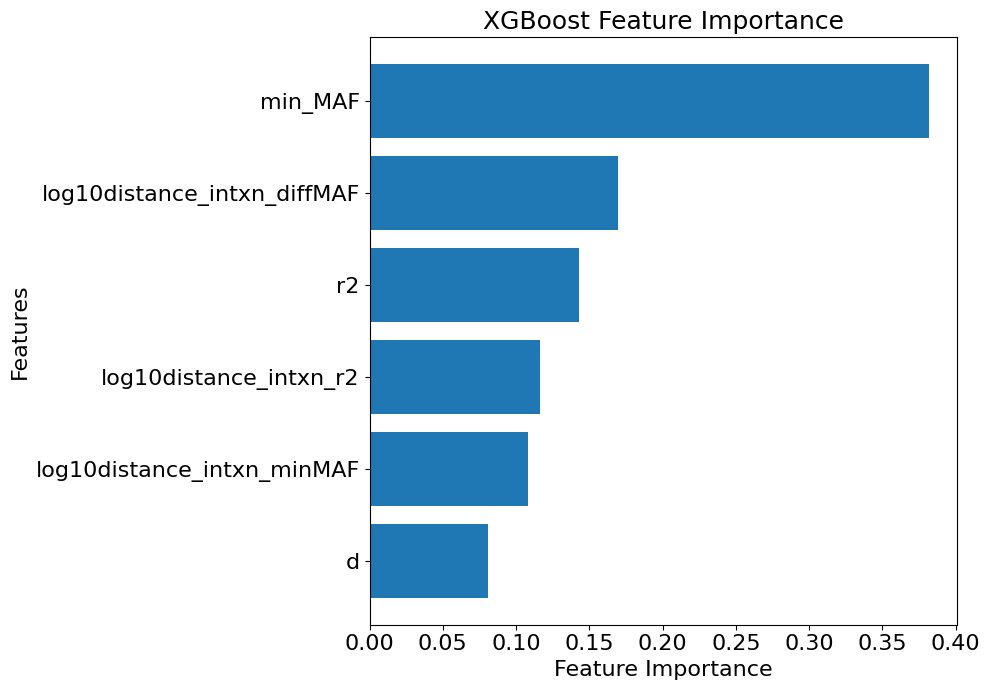

In [104]:
evaluate_model(random_search_xgb1, X1_test, y1_test, model_name="Model1")

[0]	validation_0-logloss:0.18500	validation_1-logloss:0.18412
[1]	validation_0-logloss:0.16545	validation_1-logloss:0.16425
[2]	validation_0-logloss:0.15241	validation_1-logloss:0.15167
[3]	validation_0-logloss:0.14345	validation_1-logloss:0.14315
[4]	validation_0-logloss:0.13671	validation_1-logloss:0.13663
[5]	validation_0-logloss:0.13211	validation_1-logloss:0.13292
[6]	validation_0-logloss:0.12856	validation_1-logloss:0.12946
[7]	validation_0-logloss:0.12601	validation_1-logloss:0.12705
[8]	validation_0-logloss:0.12404	validation_1-logloss:0.12559
[9]	validation_0-logloss:0.12275	validation_1-logloss:0.12445
[10]	validation_0-logloss:0.12097	validation_1-logloss:0.12279
[11]	validation_0-logloss:0.11978	validation_1-logloss:0.12168
[12]	validation_0-logloss:0.11906	validation_1-logloss:0.12113
[13]	validation_0-logloss:0.11817	validation_1-logloss:0.12033
[14]	validation_0-logloss:0.11762	validation_1-logloss:0.11984
[15]	validation_0-logloss:0.11679	validation_1-logloss:0.11873
[1

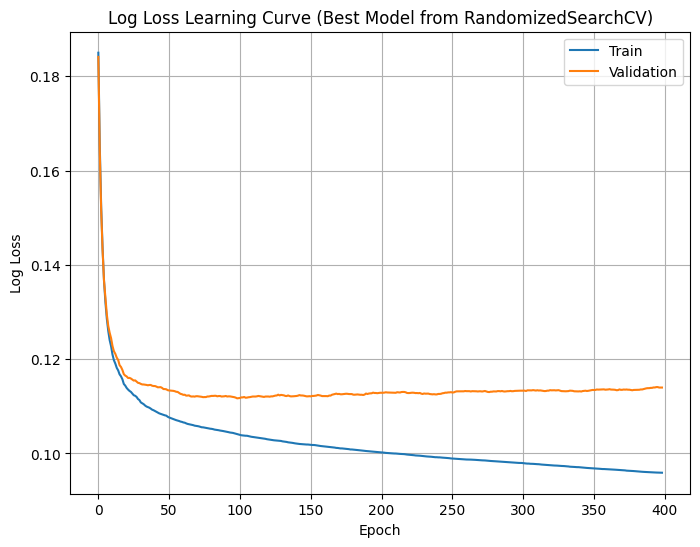

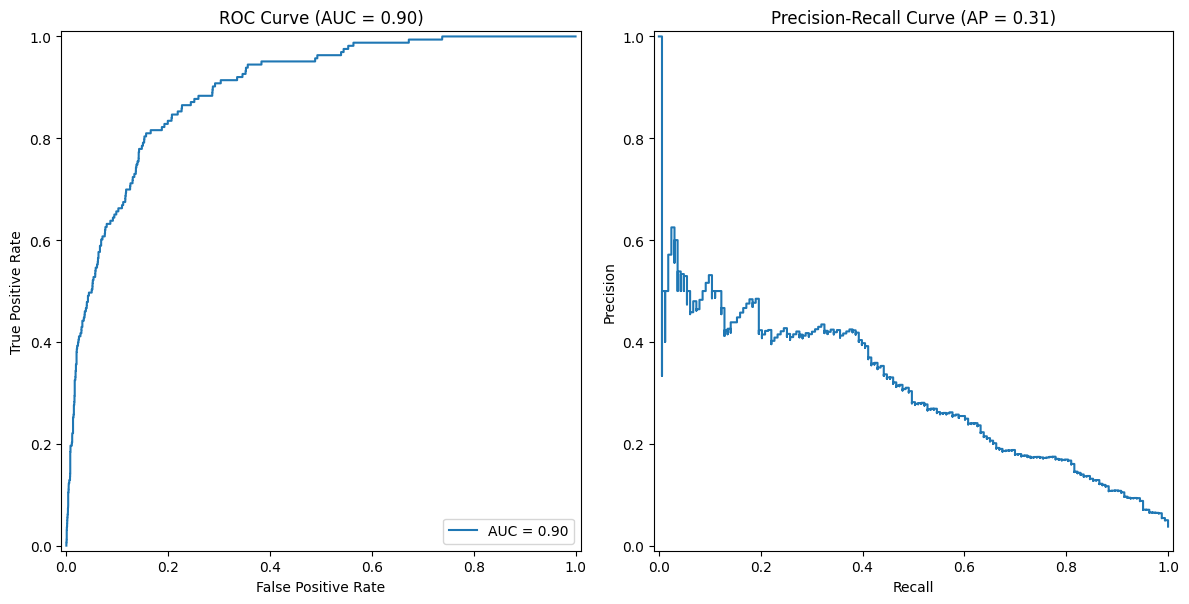

In [105]:
xgb_ypred1 = check_metric_in_test(random_search_xgb1, X1, y)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.867 total time=   0.1s
[CV 2/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.885 total time=   0.1s
[CV 3/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.884 total time=   0.1s
[CV 4/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.898 total time=   0.1s
[CV 5/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.889 total time=   0.1s
[CV 1/5] END alpha=7, colsample_bytree=0.4, gamma=1, lambda=3, max_delta_step=6, max_depth=3, min_child_we

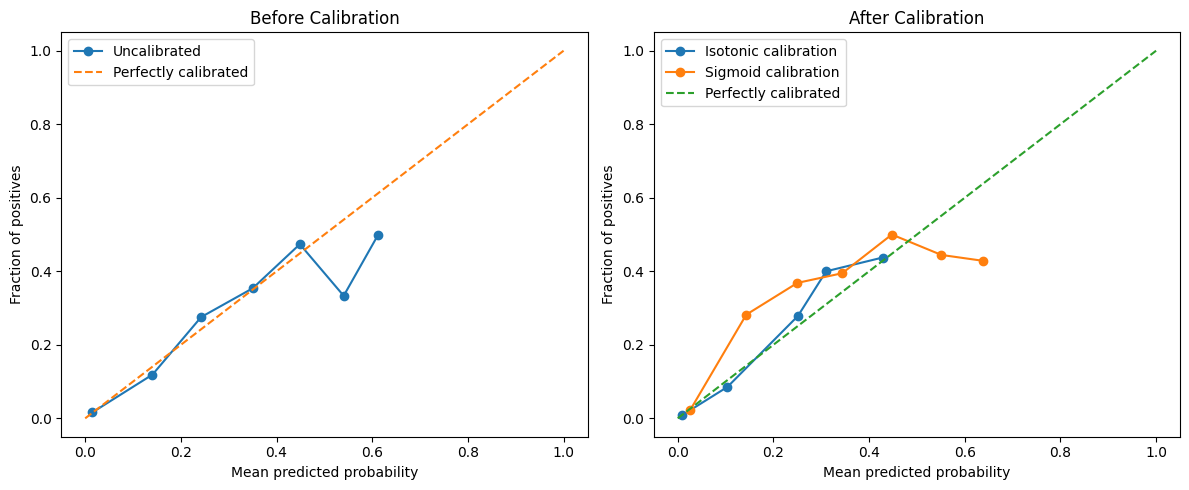

In [106]:
xgb_ypred1_iso, xgb_ypred1_sig = plot_calibration_curves(random_search_xgb1, X1_train, y1_train, X1_test, y1_test, n_bins=10)

### XGBoot Model2

In [92]:
# Step 2: Split data into training and test sets with a fixed random seed
# Assuming 'df' is your dataframe, 'target' is the binary outcome column, and 'features' is a list of feature columns
X2 = filtered_data[["d", "r2","min_MAF", "diff_MAF","log10_distance","log10distance_intxn_minMAF"]]  # Features dataframe

# Split the dataset with stratification based on the target to maintain the proportion of classes
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.25, random_state=42, stratify=y)

In [93]:
random_search_xgb2 = random_search_xgb.fit(X2_train, y2_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.885 total time=   0.2s
[CV 2/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.904 total time=   0.1s
[CV 3/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.874 total time=   0.1s
[CV 4/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.917 total time=   0.1s
[CV 5/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.887 total time=   0.1s
[CV 1/5] END alpha=7, colsample_bytree=0.4, gamma=1, lambda=3, max_delta_step=6, max_depth=3, min_child_we

### Model2
Best AUC Score: 0.89541667270316
Best Hyperparameters: {'subsample': 0.4, 'min_child_weight': 2, 'max_depth': 5, 'max_delta_step': 3, 'lambda': 5, 'gamma': 2, 'colsample_bytree': 0.4, 'alpha': 5}
Test AUC: 0.89835544277776


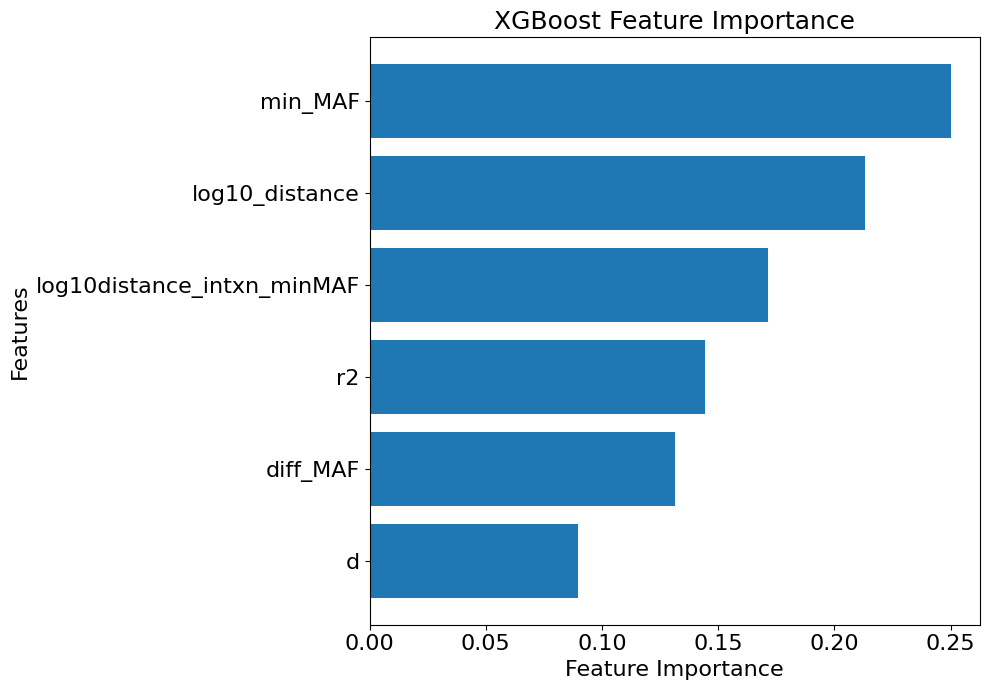

In [94]:
# Evaluate Model 2
evaluate_model(random_search_xgb2, X2_test, y2_test, model_name="Model2")

[0]	validation_0-logloss:0.19081	validation_1-logloss:0.19121
[1]	validation_0-logloss:0.16987	validation_1-logloss:0.16931
[2]	validation_0-logloss:0.15642	validation_1-logloss:0.15538
[3]	validation_0-logloss:0.14659	validation_1-logloss:0.14515
[4]	validation_0-logloss:0.13729	validation_1-logloss:0.13708
[5]	validation_0-logloss:0.12993	validation_1-logloss:0.12992
[6]	validation_0-logloss:0.12641	validation_1-logloss:0.12574


[7]	validation_0-logloss:0.12485	validation_1-logloss:0.12421
[8]	validation_0-logloss:0.12323	validation_1-logloss:0.12243
[9]	validation_0-logloss:0.12034	validation_1-logloss:0.11982
[10]	validation_0-logloss:0.11968	validation_1-logloss:0.11900
[11]	validation_0-logloss:0.11810	validation_1-logloss:0.11776
[12]	validation_0-logloss:0.11767	validation_1-logloss:0.11743
[13]	validation_0-logloss:0.11593	validation_1-logloss:0.11690
[14]	validation_0-logloss:0.11576	validation_1-logloss:0.11678
[15]	validation_0-logloss:0.11465	validation_1-logloss:0.11575
[16]	validation_0-logloss:0.11310	validation_1-logloss:0.11456
[17]	validation_0-logloss:0.11291	validation_1-logloss:0.11447
[18]	validation_0-logloss:0.11291	validation_1-logloss:0.11447
[19]	validation_0-logloss:0.11224	validation_1-logloss:0.11398
[20]	validation_0-logloss:0.11219	validation_1-logloss:0.11391
[21]	validation_0-logloss:0.11197	validation_1-logloss:0.11370
[22]	validation_0-logloss:0.11168	validation_1-logloss:0.1

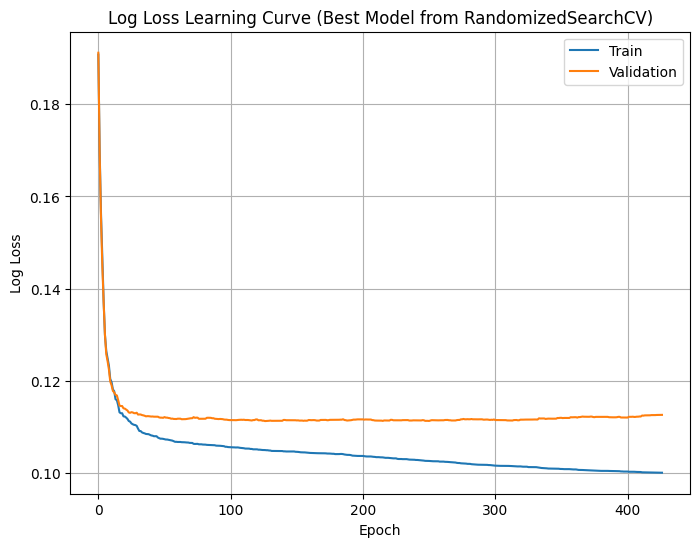

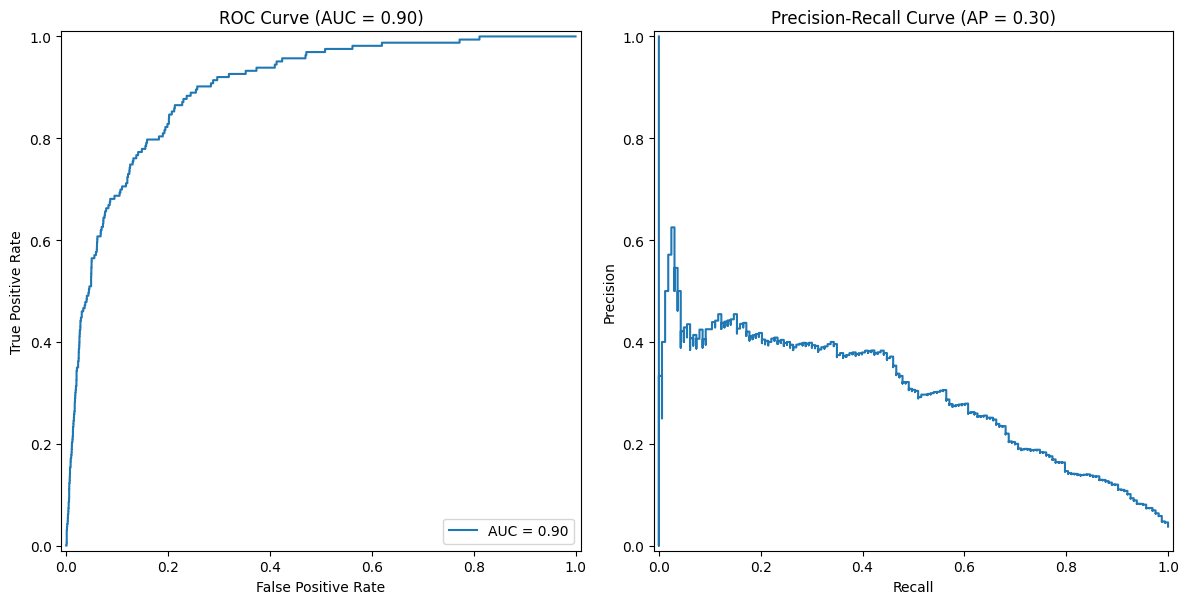

In [101]:
xgb_ypred2=check_metric_in_test(random_search_xgb2, X2, y)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.887 total time=   0.1s
[CV 2/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.908 total time=   0.1s
[CV 3/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.886 total time=   0.1s
[CV 4/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.905 total time=   0.1s
[CV 5/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.895 total time=   0.1s
[CV 1/5] END alpha=7, colsample_bytree=0.4, gamma=1, lambda=3, max_delta_step=6, max_depth=3, min_child_we

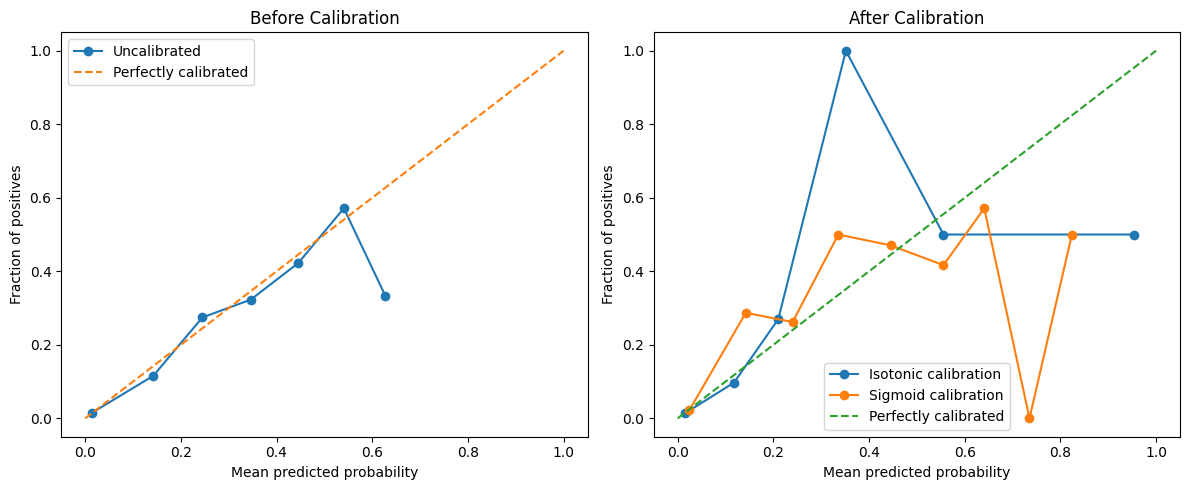

In [97]:
xgb_ypred2_iso, xgb_ypred2_sig = plot_calibration_curves(random_search_xgb2, X2_train, y2_train, X2_test, y2_test, n_bins=10)

### XGBoot Model3


In [ ]:
# Step 2: Split data into training and test sets with a fixed random seed
# Assuming 'df' is your dataframe, 'target' is the binary outcome column, and 'features' is a list of feature columns
X3 = filtered_data[["d", "r2","min_MAF", "diff_MAF","log10_distance","log10distance_intxn_r2"]]  # Features dataframe

# Split the dataset with stratification based on the target to maintain the proportion of classes
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.25, random_state=42, stratify=y)

In [41]:
random_search_xgb3 = random_search_xgb.fit(X3_train, y3_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.885 total time=   0.1s
[CV 2/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.909 total time=   0.1s
[CV 3/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.872 total time=   0.1s
[CV 4/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.917 total time=   0.1s
[CV 5/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.892 total time=   0.1s
[CV 1/5] END alpha=7, colsample_bytree=0.4, gamma=1, lambda=3, max_delta_step=6, max_depth=3, min_child_we

### Model3
Best AUC Score: 0.8958470122547814
Best Hyperparameters: {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 3, 'max_delta_step': 3, 'lambda': 5, 'gamma': 0, 'colsample_bytree': 0.4, 'alpha': 10}
Test AUC: 0.8981364410169859


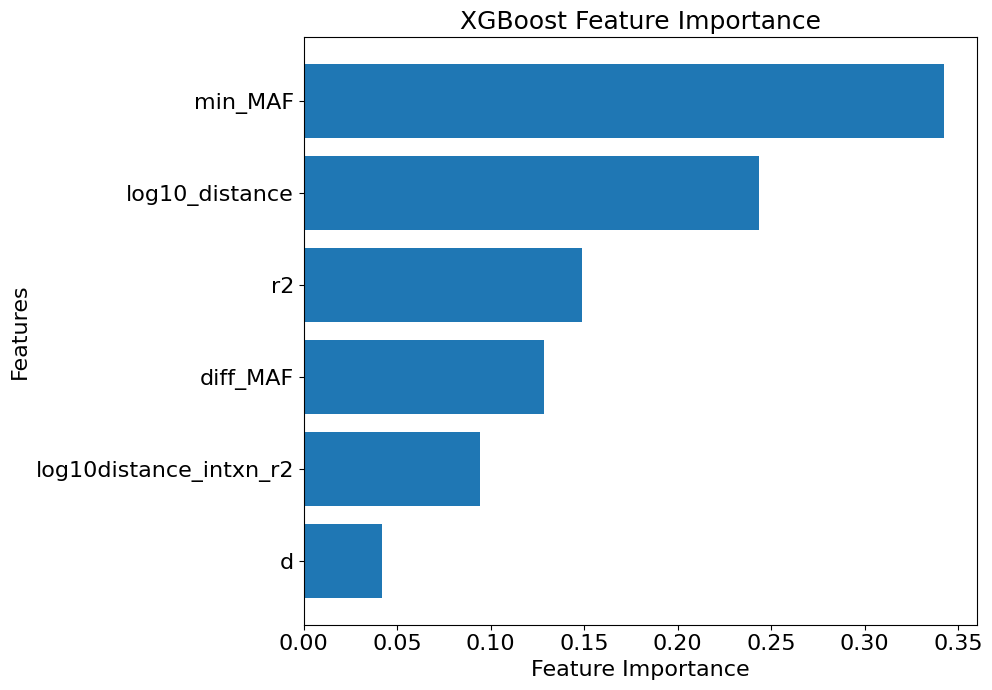

In [66]:
# Evaluate Model 3
evaluate_model(random_search_xgb3, X3_test, y3_test, model_name="Model3")

[0]	validation_0-logloss:0.19063	validation_1-logloss:0.19093
[1]	validation_0-logloss:0.16940	validation_1-logloss:0.16874
[2]	validation_0-logloss:0.15496	validation_1-logloss:0.15437
[3]	validation_0-logloss:0.14538	validation_1-logloss:0.14450
[4]	validation_0-logloss:0.13634	validation_1-logloss:0.13672
[5]	validation_0-logloss:0.12896	validation_1-logloss:0.12931
[6]	validation_0-logloss:0.12596	validation_1-logloss:0.12670
[7]	validation_0-logloss:0.12442	validation_1-logloss:0.12525
[8]	validation_0-logloss:0.12239	validation_1-logloss:0.12296
[9]	validation_0-logloss:0.12000	validation_1-logloss:0.12150
[10]	validation_0-logloss:0.11919	validation_1-logloss:0.12107
[11]	validation_0-logloss:0.11800	validation_1-logloss:0.12016
[12]	validation_0-logloss:0.11766	validation_1-logloss:0.11987
[13]	validation_0-logloss:0.11607	validation_1-logloss:0.11935
[14]	validation_0-logloss:0.11593	validation_1-logloss:0.11928
[15]	validation_0-logloss:0.11482	validation_1-logloss:0.11858
[1

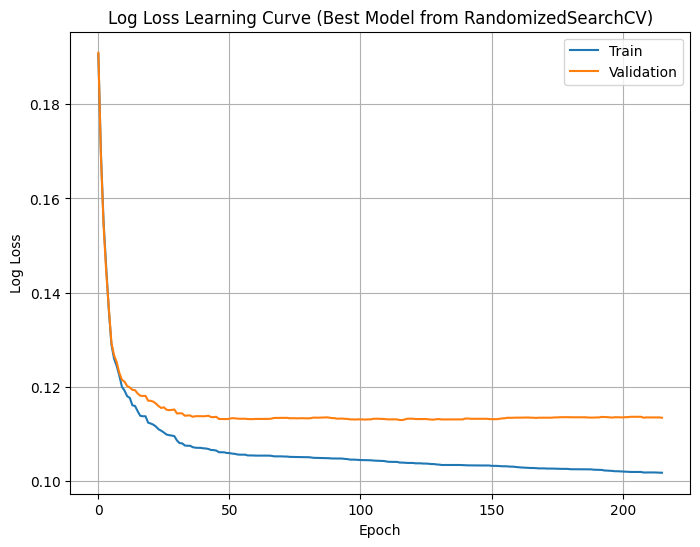

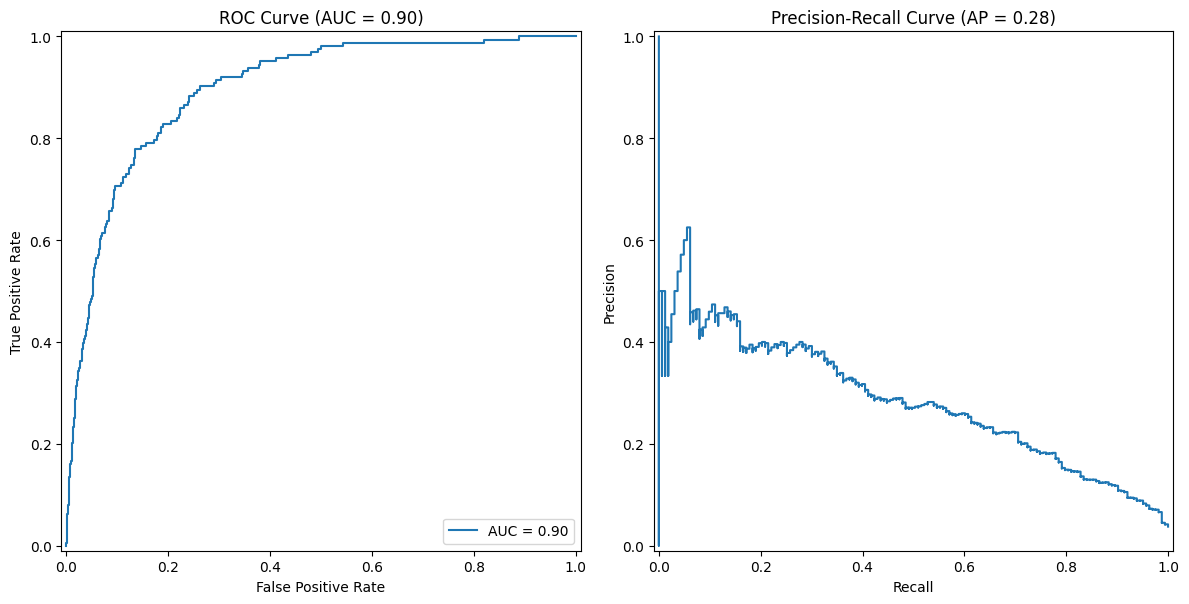

In [90]:
xgb_ypred3=check_metric_in_test(random_search_xgb3, X3, y)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.886 total time=   0.1s
[CV 2/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.912 total time=   0.1s
[CV 3/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.879 total time=   0.1s
[CV 4/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.905 total time=   0.1s
[CV 5/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.897 total time=   0.1s
[CV 1/5] END alpha=7, colsample_bytree=0.4, gamma=1, lambda=3, max_delta_step=6, max_depth=3, min_child_we

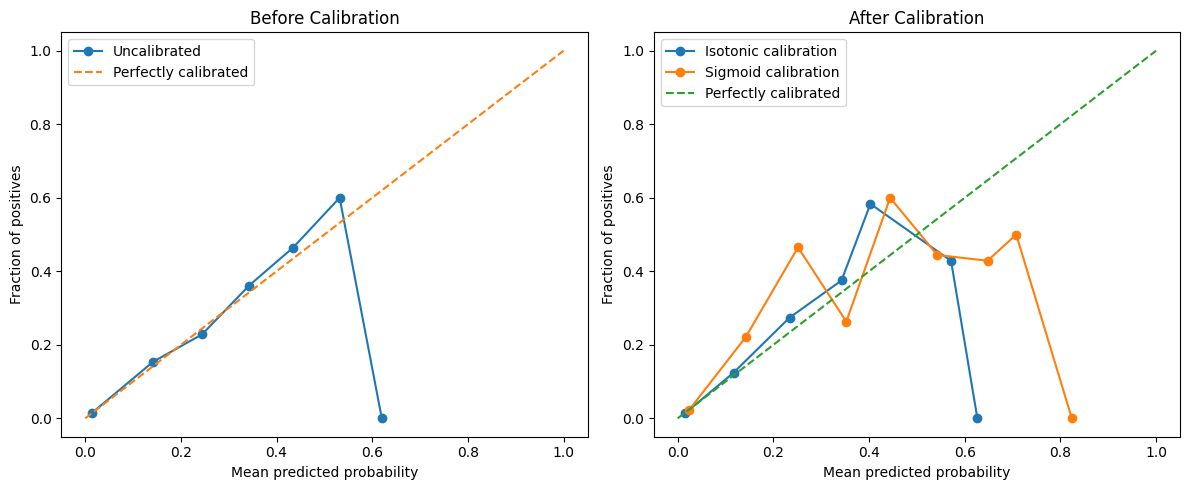

In [81]:
xgb_ypred3_iso, xgb_ypred3_sig = plot_calibration_curves(random_search_xgb3, X3_train, y3_train, X3_test, y3_test, n_bins=10)

In [91]:
xgb_ypred3

array([0.3729442 , 0.00915047, 0.20070839, ..., 0.10679856, 0.02144735,
       0.00321181], dtype=float32)

### model4

In [107]:
# Step 2: Split data into training and test sets with a fixed random seed
# Assuming 'df' is your dataframe, 'target' is the binary outcome column, and 'features' is a list of feature columns
X4 = filtered_data[["d", "r2","min_MAF", "diff_MAF","log10_distance"]]  # Features dataframe

# Split the dataset with stratification based on the target to maintain the proportion of classes
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=0.25, random_state=42, stratify=y)

In [108]:
random_search_xgb4 = random_search_xgb.fit(X4_train, y4_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.885 total time=   0.1s
[CV 2/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.906 total time=   0.1s
[CV 3/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.876 total time=   0.1s
[CV 4/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.918 total time=   0.1s
[CV 5/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.891 total time=   0.1s
[CV 1/5] END alpha=7, colsample_bytree=0.4, gamma=1, lambda=3, max_delta_step=6, max_depth=3, min_child_we

### Model4
Best AUC Score: 0.8966030684537977
Best Hyperparameters: {'subsample': 0.8, 'min_child_weight': 2, 'max_depth': 4, 'max_delta_step': 4, 'lambda': 1, 'gamma': 1, 'colsample_bytree': 0.4, 'alpha': 10}
Test AUC: 0.898925577361642


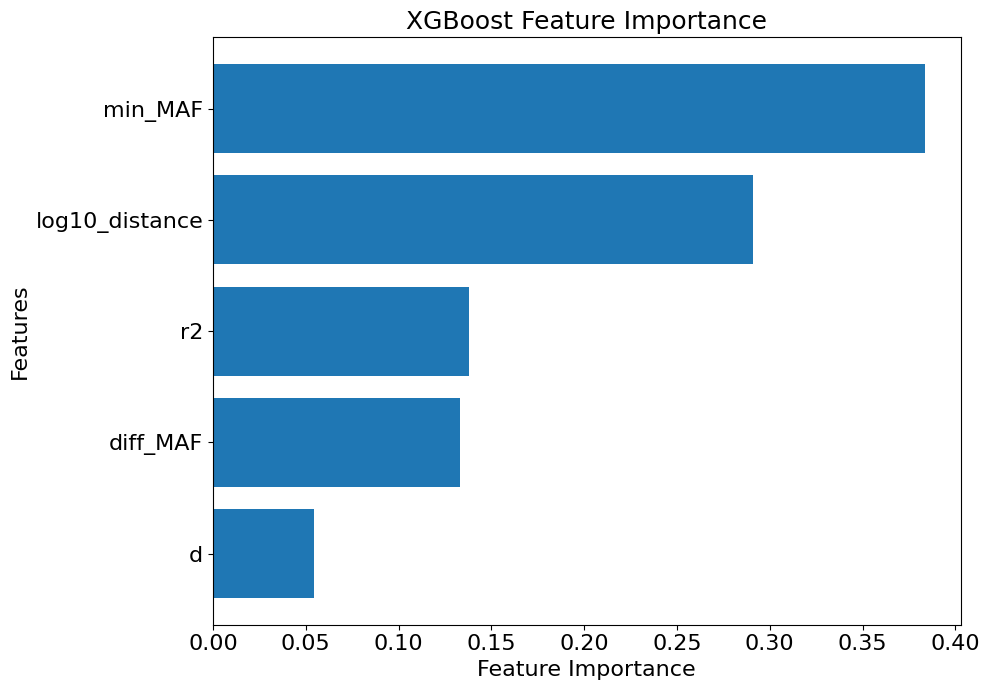

In [109]:
# Evaluate Model 3
evaluate_model(random_search_xgb4, X4_test, y4_test, model_name="Model4")

[0]	validation_0-logloss:0.19148	validation_1-logloss:0.19173
[1]	validation_0-logloss:0.16580	validation_1-logloss:0.16542
[2]	validation_0-logloss:0.15268	validation_1-logloss:0.15341
[3]	validation_0-logloss:0.14548	validation_1-logloss:0.14613
[4]	validation_0-logloss:0.13658	validation_1-logloss:0.13624
[5]	validation_0-logloss:0.12863	validation_1-logloss:0.12875
[6]	validation_0-logloss:0.12329	validation_1-logloss:0.12355
[7]	validation_0-logloss:0.11983	validation_1-logloss:0.12117
[8]	validation_0-logloss:0.11674	validation_1-logloss:0.11809
[9]	validation_0-logloss:0.11546	validation_1-logloss:0.11721
[10]	validation_0-logloss:0.11363	validation_1-logloss:0.11546
[11]	validation_0-logloss:0.11299	validation_1-logloss:0.11478
[12]	validation_0-logloss:0.11237	validation_1-logloss:0.11439
[13]	validation_0-logloss:0.11203	validation_1-logloss:0.11424
[14]	validation_0-logloss:0.11190	validation_1-logloss:0.11413
[15]	validation_0-logloss:0.11133	validation_1-logloss:0.11336
[1

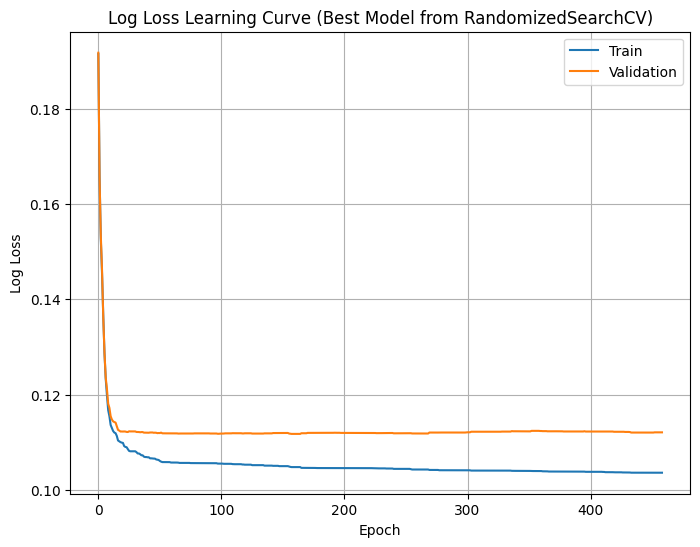

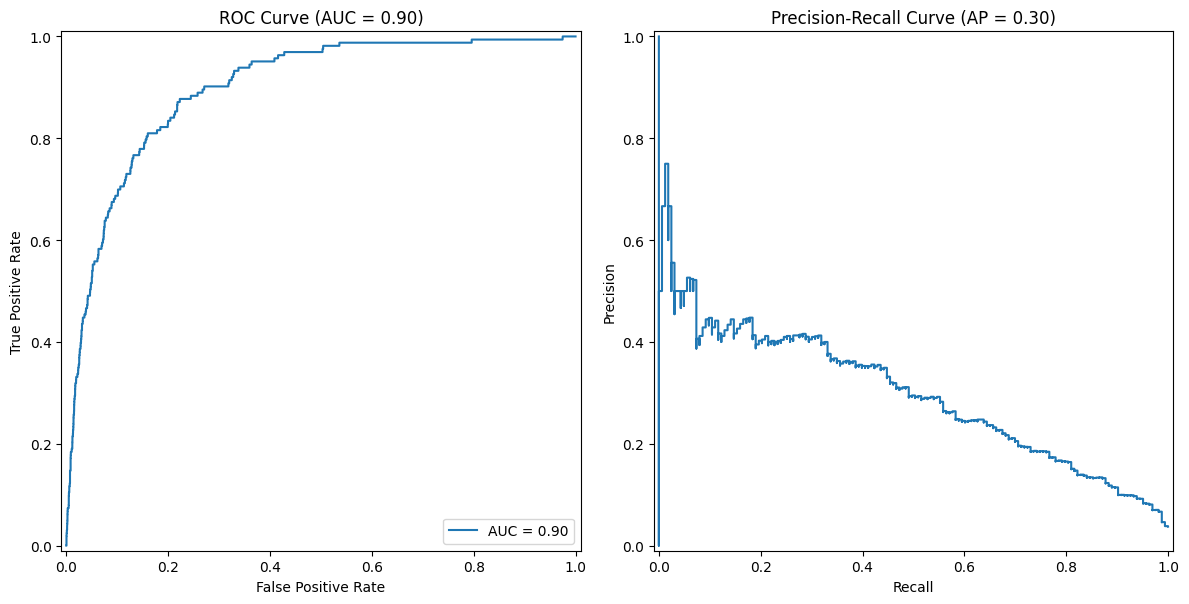

In [110]:
xgb_ypred4 = check_metric_in_test(random_search_xgb4, X4, y)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.890 total time=   0.1s
[CV 2/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.909 total time=   0.1s
[CV 3/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.883 total time=   0.1s
[CV 4/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.904 total time=   0.1s
[CV 5/5] END alpha=10, colsample_bytree=0.6, gamma=0.5, lambda=5, max_delta_step=3, max_depth=5, min_child_weight=0.5, subsample=0.8;, score=0.896 total time=   0.1s
[CV 1/5] END alpha=7, colsample_bytree=0.4, gamma=1, lambda=3, max_delta_step=6, max_depth=3, min_child_we

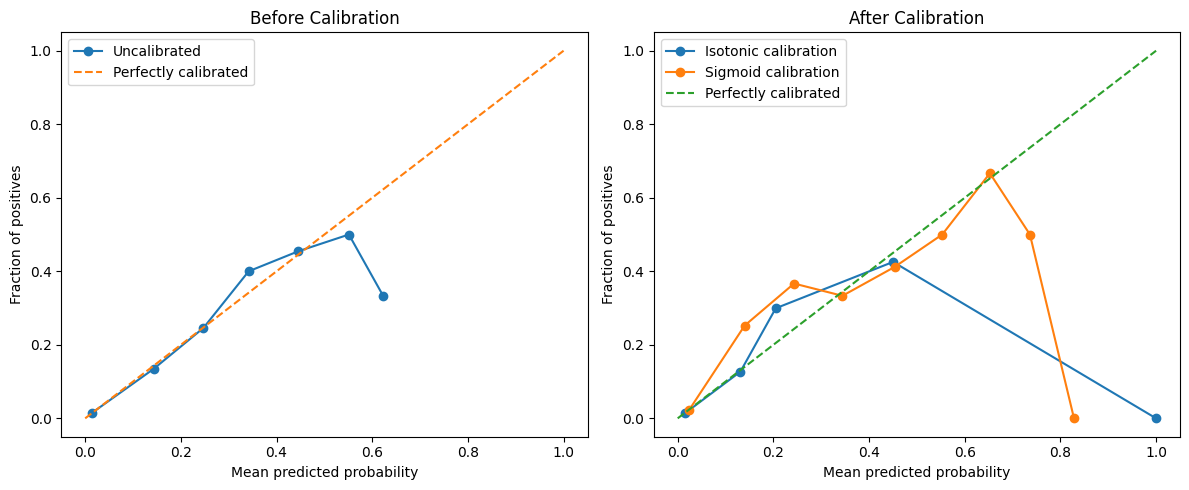

In [111]:
xgb_ypred4_iso, xgb_ypred4_sig = plot_calibration_curves(random_search_xgb4, X4_train, y4_train, X4_test, y4_test, n_bins=10)

## Logistic Regression

In [112]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # More values for regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization types
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],  # Include more solvers that support l2 or no penalty
    'max_iter': [100, 200, 300, 500],  # More options for iterations
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Exploring more values for elasticnet (only needed for elasticnet)
}

# Initialize the logistic regression model
logreg = LogisticRegression()

# Set up RandomizedSearchCV to search for best hyperparameters using AUC as the scoring metric
random_search_logreg = RandomizedSearchCV(
    estimator=logreg, 
    param_distributions=param_grid, 
    n_iter=20,  # Number of parameter settings sampled
    scoring='roc_auc',  # Use AUC as the evaluation metric
    n_jobs=1,  # Utilize all available cores
    cv=skf,  # Stratified K-Fold
    verbose=3, 
    random_state=1001
)


### LR Model1

In [113]:
# Fit the logistic regression model
random_search_logreg1 = random_search_logreg.fit(X1_train, y1_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.863 total time=   0.3s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.862 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.826 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.884 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.879 total time=   0.4s
[CV 1/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.869 total time=   0.0s
[CV 2/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.866 total time=   0.0s
[CV 3/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.835 total

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.834 total time=   0.0s
[CV 4/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.888 total time=   0.0s
[CV 5/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.882 total time=   0.0s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.870 total time=   0.0s
[CV 2/5]

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 1/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.813 total time=   0.1s
[CV 2/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.813 total time=   0.1s
[CV 3/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.785 total time=   0.1s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 4/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.845 total time=   0.1s
[CV 5/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.844 total time=   0.1s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.766 total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.749 total time=   0.0s
[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.742 total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.808 total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.794 total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
70 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/scarlett/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/scarlett/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/scarlett/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/scar

Best AUC Score: 0.8689888427199813
Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'l1_ratio': 0.3, 'C': 1000}
Training AUC: 0.870, Test AUC: 0.866
Training Log Loss: 0.124, Test Log Loss: 0.124


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

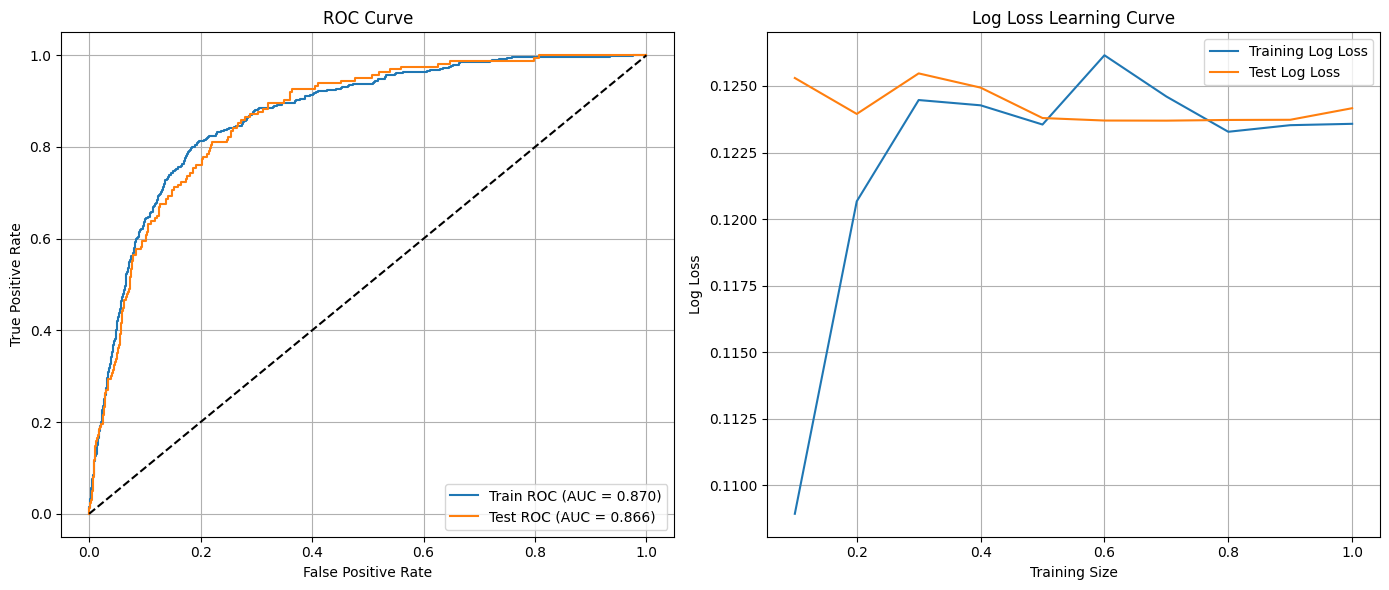

In [117]:
logreg_ypred1 = check_logreg_metrics_on_test(random_search_logreg, X1_train, y1_train, X1_test, y1_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.857 total time=   0.3s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.869 total time=   0.3s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.832 total time=   0.3s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.885 total time=   0.3s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.862 total time=   0.3s
[CV 1/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.864 total time=   0.0s
[CV 2/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.874 total time=   0.0s
[CV 3/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.845 total

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 4/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.889 total time=   0.0s
[CV 5/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.865 total time=   0.0s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.864 total time=   0.0s
[CV 2/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.874 total time=   0.0s
[CV 3/5] EN

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 1/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.815 total time=   0.1s
[CV 2/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.819 total time=   0.1s
[CV 3/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.792 total time=   0.1s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 4/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.839 total time=   0.1s
[CV 5/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.813 total time=   0.1s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.771 total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.773 total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.768 total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.757 total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
70 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/scarlett/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/scarlett/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/scarlett/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/scar

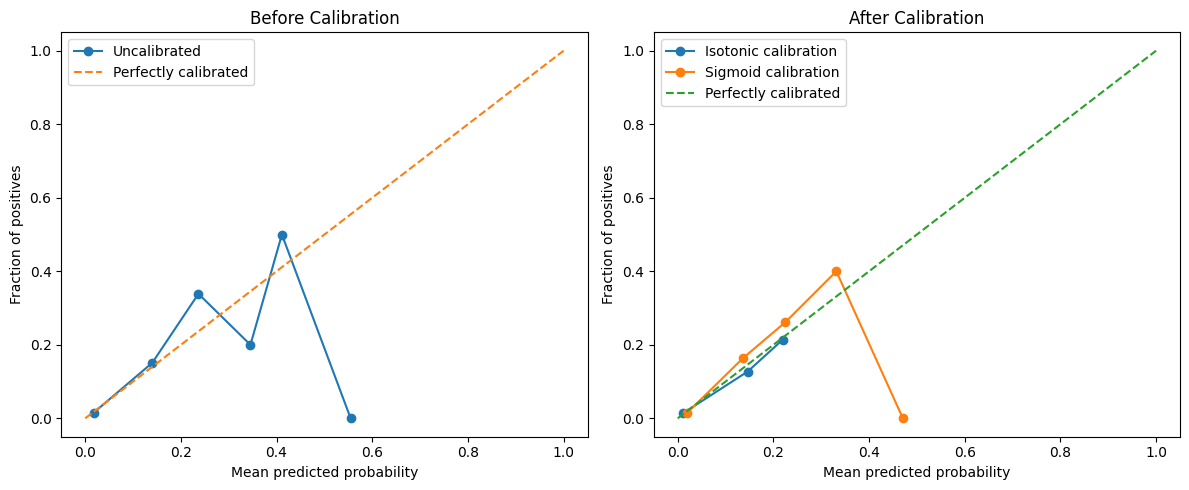

In [119]:
logreg_ypred1_iso, logreg_ypred1_sig = plot_calibration_curves(random_search_logreg1, X1_train, y1_train, X1_test, y1_test, n_bins=10)

### LR model2

In [121]:
# Fit the logistic regression model
random_search_logreg2 = random_search_logreg.fit(X2_train, y2_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.860 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.848 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.832 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.879 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.874 total time=   0.4s
[CV 1/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.868 total time=   0.0s
[CV 2/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.858 total time=   0.0s
[CV 3/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.839 total

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 2/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.858 total time=   0.0s
[CV 3/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.839 total time=   0.0s
[CV 4/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.886 total time=   0.0s
[CV 5/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.880 total time=   0.0s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.830 total time=   0.1s
[CV 2/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.806 total time=   0.1s
[CV 3/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.800 total time=   0.1s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 4/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.843 total time=   0.1s
[CV 5/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.842 total time=   0.1s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.823 total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.800 total time=   0.0s
[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.787 total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.833 total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.828 total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

Best AUC Score: 0.8672087349291704
Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'l1_ratio': 0.3, 'C': 1000}
Training AUC: 0.868, Test AUC: 0.868
Training Log Loss: 0.124, Test Log Loss: 0.124


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

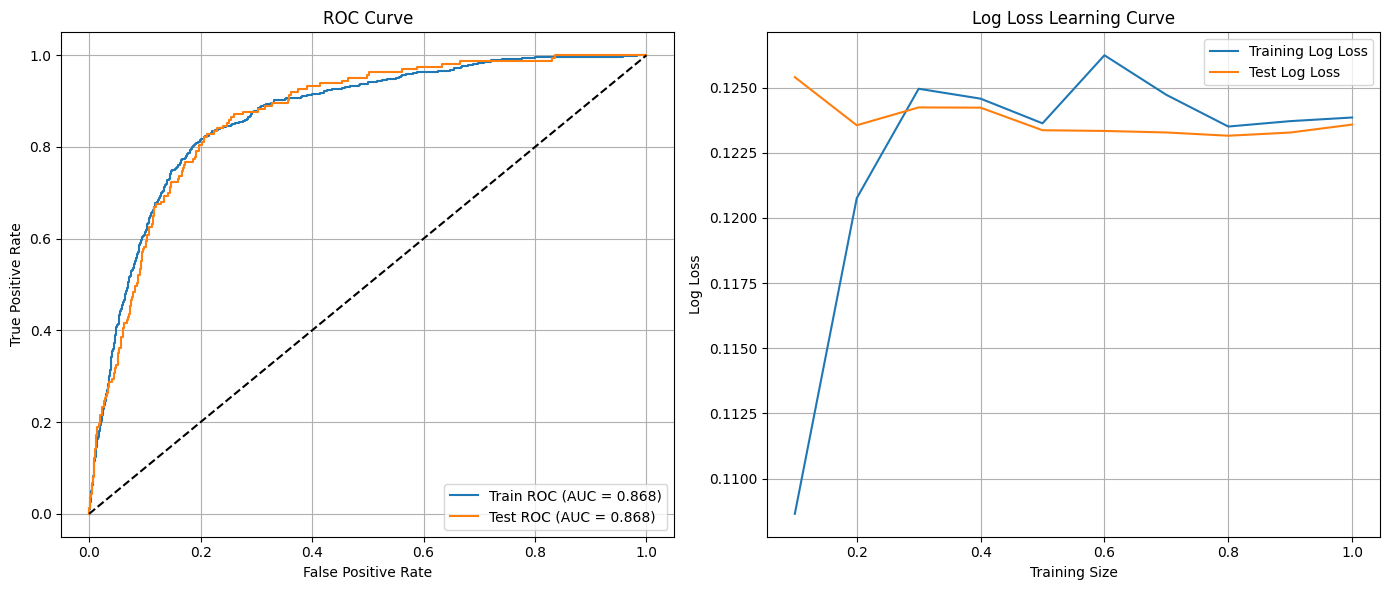

In [123]:
logreg_ypred2 = check_logreg_metrics_on_test(random_search_logreg2, X2_train, y2_train, X2_test, y2_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.853 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.868 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.840 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.877 total time=   0.4s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.853 total time=   0.4s
[CV 1/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.861 total time=   0.0s
[CV 2/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.872 total time=   0.0s
[CV 3/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.851 total

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.851 total time=   0.0s
[CV 4/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 5/5] END C=100, l1_ratio=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.860 total time=   0.0s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.862 total time=   0.0s
[CV 2/5]

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 2/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.845 total time=   0.1s
[CV 3/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.794 total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.841 total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.820 total time=   0.0s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.814 total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.838 total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.769 total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.838 total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.816 total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

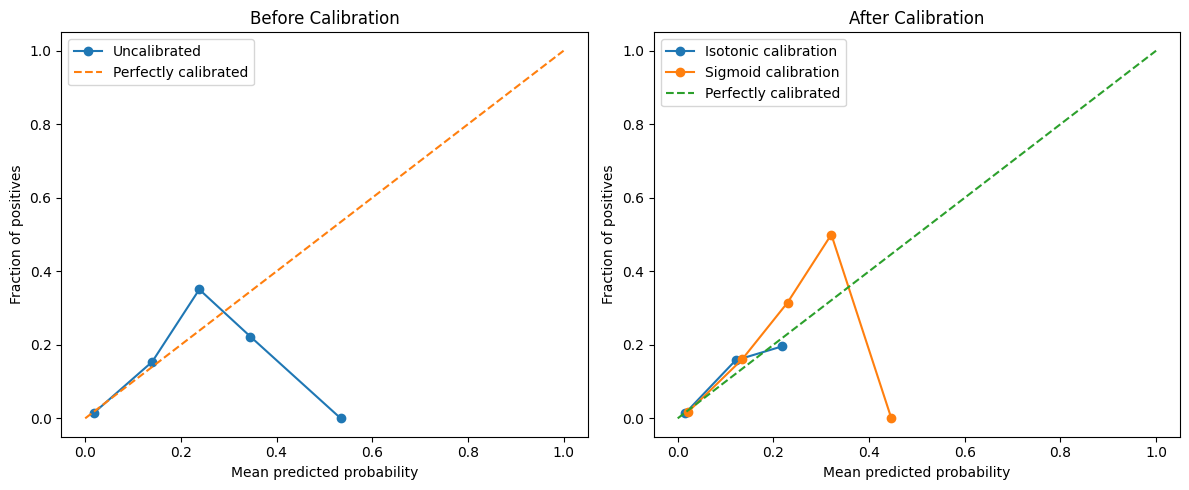

In [124]:
logreg_ypred2_iso, logreg_ypred2_sig = plot_calibration_curves(random_search_logreg2, X2_train, y2_train, X2_test, y2_test, n_bins=10)

### LR model3

In [125]:
# Fit the logistic regression model
random_search_logreg3 = random_search_logreg.fit(X3_train, y3_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.835 total time=   0.1s
[CV 3/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.813 total time=   0.2s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.863 total time=   0.1s
[CV 5/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.863 total time=   0.1s
[CV 1/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.841 total time=   0.0s
[CV 2/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.835 total time=

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 4/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.863 total time=   0.0s
[CV 5/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.863 total time=   0.0s
[CV 1/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.7, max_iter=500, p

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 4/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.862 total time=   0.0s
[CV 5/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.863 total time=   0.0s
[CV 1/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.842 total time=   0.1s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 2/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.821 total time=   0.1s
[CV 3/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.810 total time=   0.1s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.855 total time=   0.1s
[CV 5/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.853 total time=   0.1s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.801 total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.762 total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.751 total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.810 total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.801 total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

Best AUC Score: 0.8429921082599192
Best Hyperparameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 500, 'l1_ratio': 0.5, 'C': 10}
Training AUC: 0.845, Test AUC: 0.829
Training Log Loss: 0.128, Test Log Loss: 0.132


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

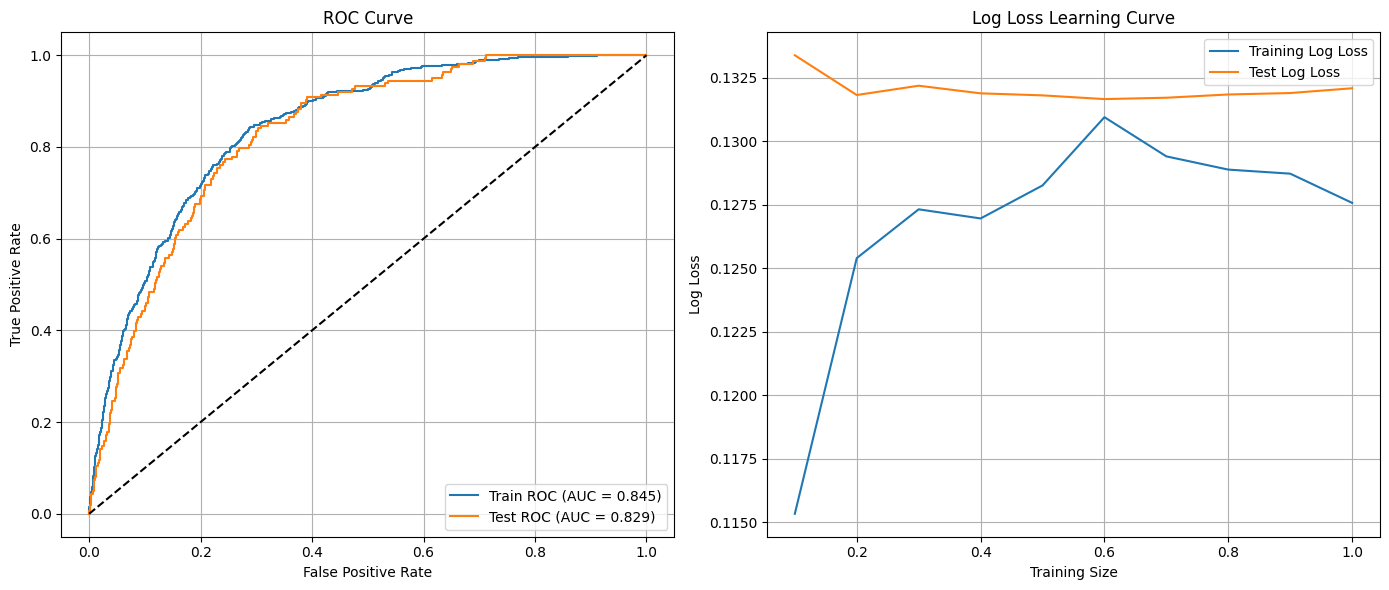

In [126]:
logreg_ypred3 = check_logreg_metrics_on_test(random_search_logreg3, X3_train, y3_train, X3_test, y3_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.858 total time=   0.1s
[CV 3/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.814 total time=   0.2s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.862 total time=   0.1s
[CV 5/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.841 total time=   0.1s
[CV 1/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.839 total time=   0.0s
[CV 2/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.858 total time=

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 5/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.841 total time=   0.0s
[CV 1/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.7, max_iter=500, penalty

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 5/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.840 total time=   0.0s
[CV 1/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.833 total time=   0.1s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.857 total time=   0.1s
[CV 3/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.800 total time=   0.1s
[CV 4/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.852 total time=   0.1s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 5/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.833 total time=   0.1s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.786 total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.823 total time=   0.0s
[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.734 total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.797 total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.797 total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] EN

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

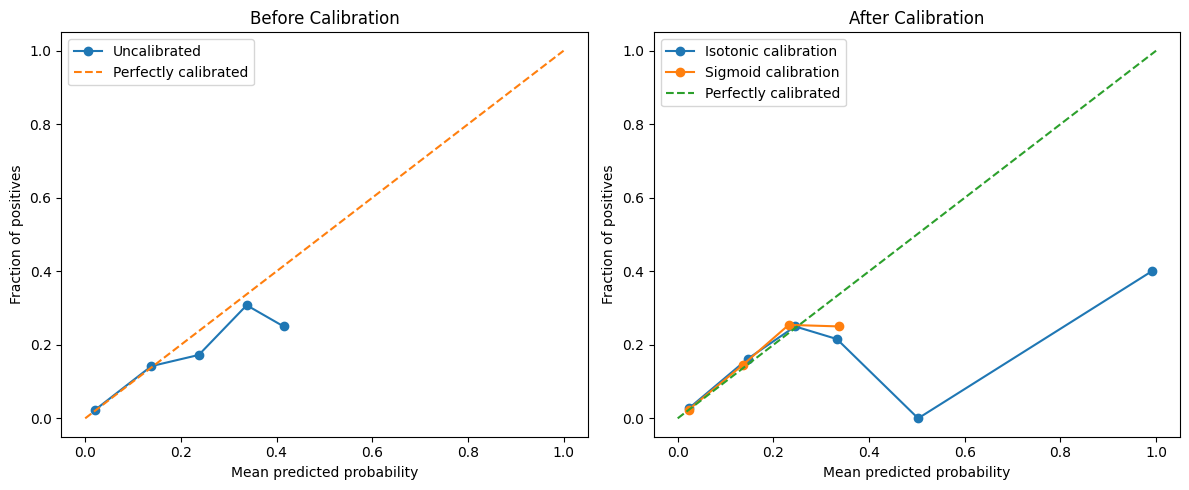

In [127]:
logreg_ypred3_iso, logreg_ypred3_sig = plot_calibration_curves(random_search_logreg3, X3_train, y3_train, X3_test, y3_test, n_bins=10)

### LR model4

In [128]:
# Fit the logistic regression model
random_search_logreg4 = random_search_logreg.fit(X4_train, y4_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.819 total time=   0.1s
[CV 4/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.860 total time=   0.1s
[CV 5/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.858 total time=   0.1s
[CV 1/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.841 total time=   0.0

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.819 total time=   0.0s
[CV 4/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.860 total time=   0.0s
[CV 5/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.858 total time=   0.0s
[CV 1/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.819 total time=   0.0s
[CV 4/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.860 total time=   0.0s
[CV 5/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.858 total time=   0.0s
[CV 1/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.842 total time=   0.1s
[CV 

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.810 total time=   0.1s
[CV 4/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.855 total time=   0.1s
[CV 5/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.853 total time=   0.1s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.795 total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.765 total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.753 total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.806 total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.796 total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/s

Best AUC Score: 0.8409860281369447
Best Hyperparameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 500, 'l1_ratio': 0.5, 'C': 10}
Training AUC: 0.842, Test AUC: 0.834
Training Log Loss: 0.129, Test Log Loss: 0.132


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

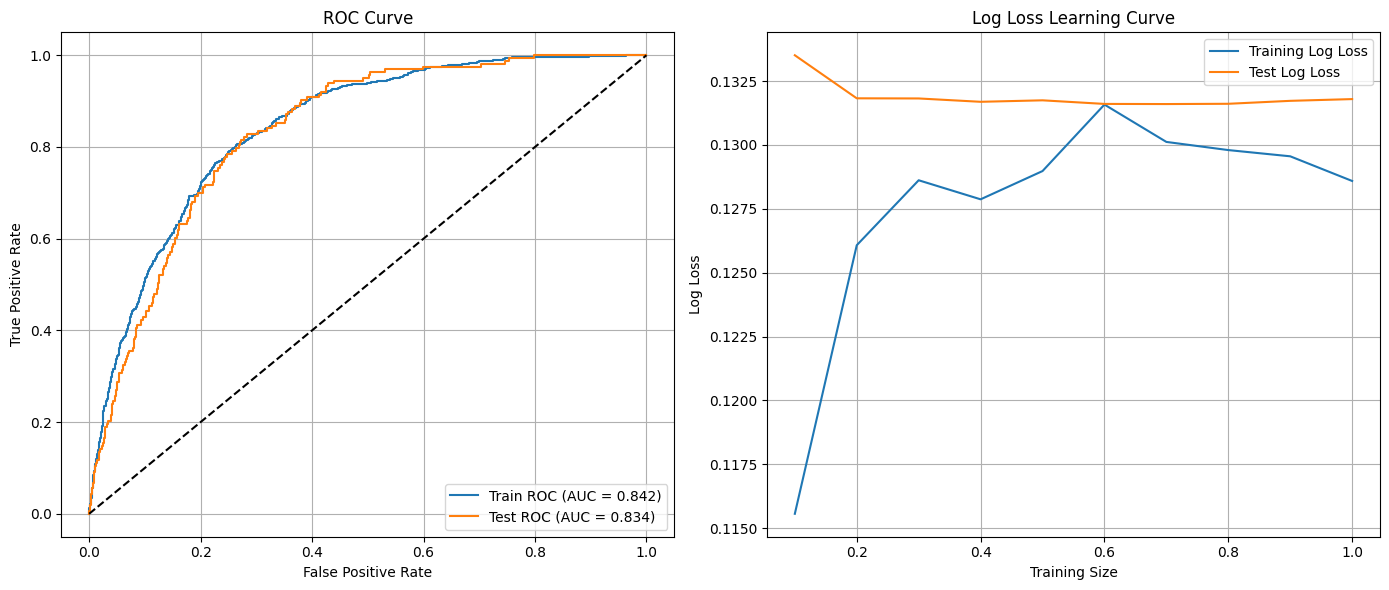

In [129]:
logreg_ypred4 = check_logreg_metrics_on_test(random_search_logreg4, X4_train, y4_train, X4_test, y4_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=none, solver=lbfgs;, score=nan total time

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.826 total time=   0.1s
[CV 4/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.859 total time=   0.1s
[CV 5/5] END C=10, l1_ratio=0.5, max_iter=500, penalty=l2, solver=saga;, score=0.833 total time=   0.1s
[CV 1/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.1, max_iter=200, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.836 total time=   0.0

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.827 total time=   0.0s
[CV 4/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.858 total time=   0.0s
[CV 5/5] END C=100, l1_ratio=0.3, max_iter=100, penalty=l2, solver=liblinear;, score=0.832 total time=   0.0s
[CV 1/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, l1_ratio=0.9, max_iter=100, penalty=none, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=1, l1_ratio=0.7, max_iter=500, penalty=none, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.7, max_iter=

/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 4/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.858 total time=   0.0s
[CV 5/5] END C=1000, l1_ratio=0.3, max_iter=300, penalty=l2, solver=lbfgs;, score=0.832 total time=   0.0s
[CV 1/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=1, l1_ratio=0.9, max_iter=500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.833 total time=   0.1s
[CV 2/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.857 total time=   0.1s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.800 total time=   0.1s
[CV 4/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.853 total time=   0.1s
[CV 5/5] END C=0.1, l1_ratio=0.7, max_iter=100, penalty=l1, solver=saga;, score=0.833 total time=   0.1s
[CV 1/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.784 total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.812 total time=   0.0s


/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scarlett/.local/lib/python3.10/site-packages/s

[CV 3/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.725 total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.809 total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.3, max_iter=300, penalty=l2, solver=saga;, score=0.793 total time=   0.0s
[CV 1/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, l1_ratio=0.7, max_iter=300, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s


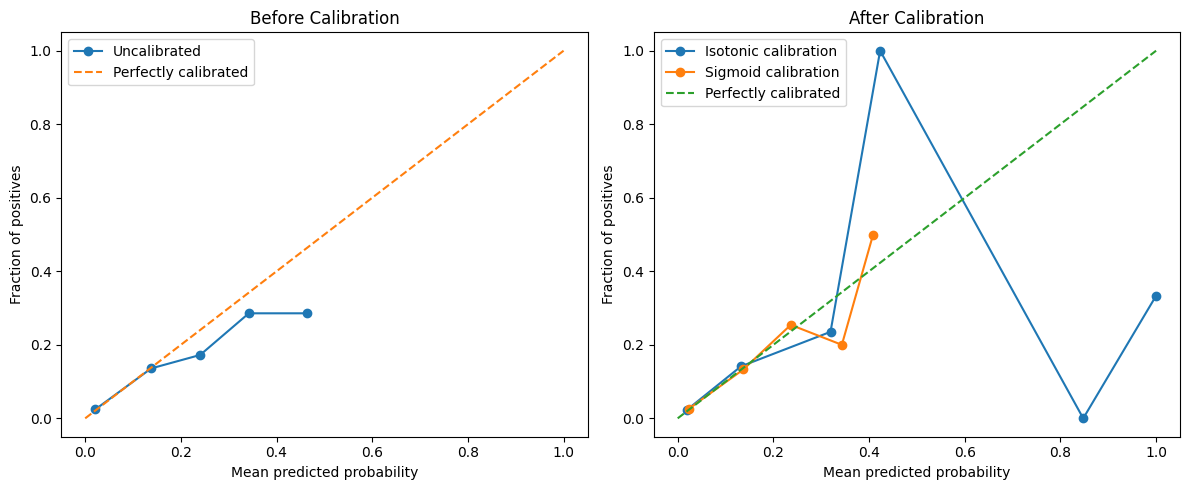

In [130]:
logreg_ypred4_iso, logreg_ypred4_sig = plot_calibration_curves(random_search_logreg4, X4_train, y4_train, X4_test, y4_test, n_bins=10)

### Output the test set with predicted prob

In [132]:
X_final = filtered_data[["d", "r2","min_MAF", "diff_MAF","lag_MAF","log10_distance"]]  # Features dataframe
y_final = filtered_data[["error"]]    # Binary outcome

# Split the dataset with stratification based on the target to maintain the proportion of classes
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X_final, y_final, test_size=0.25, random_state=42, stratify=y_final)

In [133]:
# Create a new dataframe that includes the test data, predicted probabilities, and ground truth values
test_output = X_final_test.copy()
test_output['error'] = y_final_test.values

In [134]:
#test_output['xgb_pred_prob_cali'] = calibrated_probs
test_output['xgb_pred_prob'] = xgb_ypred4
#test_output['log_pred_prob_cali'] = calibrated_probs_logreg
test_output['log_pred_prob'] = logreg_ypred2_iso
test_output.head()

d     r2  min_MAF  diff_MAF  lag_MAF  log10_distance  error  \
3328   1.0  0.001   0.0010    0.1402   0.0010        1.716003    0.0   
14002  1.0  0.057   0.1561    0.0497   0.1561        2.471292    0.0   
8269   0.2  0.033   0.0845    0.3111   0.3956        4.856904    0.0   
6710   1.0  0.002   0.4076    0.0000   0.4076        2.214844    0.0   
11897  1.0  0.068   0.0765    0.2883   0.0765        2.648360    0.0   

       xgb_pred_prob  log_pred_prob  
3328        0.404808       0.120879  
14002       0.007712       0.006803  
8269        0.227187       0.269231  
6710        0.005385       0.000000  
11897       0.010459       0.033333

In [135]:
test_output.shape

(4365, 9)

In [136]:
# show the first 5 rows of the test_output dataframe with True_error == 1
test_output[test_output['error'] == 1].head()

d     r2  min_MAF  diff_MAF  lag_MAF  log10_distance  error  \
6644   0.251  0.015   0.0020    0.3827   0.3847        2.974051    1.0   
531    1.000  0.003   0.0070    0.3449   0.0070        5.160357    1.0   
2026   1.000  1.000   0.3002    0.0080   0.3002        5.101207    1.0   
12234  1.000  0.025   0.0358    0.0835   0.1193        2.630428    1.0   
9467   1.000  1.000   0.0010    0.1262   0.1272        2.079181    1.0   

       xgb_pred_prob  log_pred_prob  
6644        0.413734       0.203125  
531         0.320783       0.269231  
2026        0.122816       0.120879  
12234       0.016056       0.085106  
9467        0.325266       0.045455

In [137]:
# Assuming 'test_output' DataFrame is already defined and includes the necessary columns
# Calculate the mean values
mean_values = {
    'XGB Mean Predicted Probability': [test_output['xgb_pred_prob'].mean()],
    'Log Mean Predicted Probability': [test_output['log_pred_prob'].mean()],
    'Mean True Error Rate': [test_output['error'].mean()]
}

# Create a DataFrame to display these mean values as a table
mean_df = pd.DataFrame(mean_values)
mean_df

XGB Mean Predicted Probability  Log Mean Predicted Probability  \
0                        0.037062                        0.036975   

   Mean True Error Rate  
0              0.037342

In [138]:
test_output.shape

(4365, 9)

In [139]:
filtered_data

chr        pos           geneID  error      d     r2        AF  \
0       chr1  196642533  ENSG00000000971    0.0  0.740  1.000  0.468251   
1       chr1  196646387  ENSG00000000971    0.0  0.443  0.079  0.257188   
2       chr1  196682947  ENSG00000000971    0.0  1.000  0.019  0.479034   
3       chr6  143823112  ENSG00000001036    0.0  1.000  0.544  0.170128   
4       chr6  143825104  ENSG00000001036    0.0  1.000  0.091  0.089057   
...      ...        ...              ...    ...    ...    ...       ...   
17454  chr12   14019157  ENSG00000273079    0.0  1.000  0.042  0.037939   
17455   chr1   32961534  ENSG00000273274    0.0  1.000  0.091  0.001997   
17456   chr7  130623257  ENSG00000273319    0.0  1.000  0.539  0.835663   
17457   chr7  130623437  ENSG00000273319    0.0  1.000  0.605  0.942492   
17458   chr7  130623889  ENSG00000273319    0.0  1.000  1.000  0.836861   

            MAF  lag_MAF  min_MAF  diff_MAF  log10_distance  \
0      0.468251   0.2604   0.2604    0.0000        2.477121   
1      0.257188   0.2604   0.2604    0.0040        3.585912   
2      0.479034   0.2644   0.2644    0.1591        4.563006   
3      0.170128   0.2247   0.2247    0.0000        3.844415   
4      0.089057   0.2247   0.2247    0.0477        3.299289   
...         ...      ...      ...       ...             ...   
17454  0.037939   0.1829   0.1163    0.0666        5.497162   
17455  0.001997   0.0795   0.0089    0.0706        3.484442   
17456  0.164337   0.2097   0.1571    0.0526        2.840733   
17457  0.057508   0.1571   0.0974    0.0597        2.255272   
17458  0.163139   0.0974   0.0974    0.0597        2.655138   

       log10distance_intxn_r2  log10distance_intxn_minMAF  \
0                    2.477121                    0.645042   
1                    0.283287                    0.933771   
2                    0.086697                    1.206459   
3                    2.091362                    0.863840   
4                    0.300235                    0.741350   
...                       ...                         ...   
17454                0.230881                    0.639320   
17455                0.317084                    0.031012   
17456                1.531155                    0.446279   
17457                1.364440                    0.219664   
17458                2.655138                    0.258610   

       log10distance_intxn_diffMAF  binned  
0                         0.000000       0  
1                         0.014344       0  
2                         0.725974      11  
3                         0.000000       0  
4                         0.157376       2  
...                            ...     ...  
17454                     0.366111       5  
17455                     0.246002       3  
17456                     0.149423       2  
17457                     0.134640       2  
17458                     0.158512       2  

[17459 rows x 16 columns]

In [159]:
# Step 2: Split data into training and test sets with a fixed random seed
# Assuming 'df' is your dataframe, 'target' is the binary outcome column, and 'features' is a list of feature columns
X = filtered_data[["geneID","log10distance_intxn_r2","log10distance_intxn_minMAF","log10distance_intxn_diffMAF","error"]]  # Features dataframe
y = filtered_data[["error"]]    # Binary outcome

# Split the dataset with stratification based on the target to maintain the proportion of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [160]:
X_test.head(n=2)

geneID  log10distance_intxn_r2  log10distance_intxn_minMAF  \
3328   ENSG00000106261                0.001716                    0.001716   
14002  ENSG00000182087                0.140864                    0.385769   

       log10distance_intxn_diffMAF  error  
3328                      0.240584    0.0  
14002                     0.122823    0.0

In [161]:
test_output.head(n=2)

d     r2  min_MAF  diff_MAF  lag_MAF  log10_distance  error  \
3328   1.0  0.001   0.0010    0.1402   0.0010        1.716003    0.0   
14002  1.0  0.057   0.1561    0.0497   0.1561        2.471292    0.0   

       xgb_pred_prob  log_pred_prob  
3328        0.404808       0.120879  
14002       0.007712       0.006803

In [166]:
# Rejoining the predictions with testset based on the index
testset_with_predictions = pd.concat([X_test, test_output], axis=1)
testset_with_predictions.head(n=2)

geneID  log10distance_intxn_r2  log10distance_intxn_minMAF  \
3328   ENSG00000106261                0.001716                    0.001716   
14002  ENSG00000182087                0.140864                    0.385769   

       log10distance_intxn_diffMAF  error    d     r2  min_MAF  diff_MAF  \
3328                      0.240584    0.0  1.0  0.001   0.0010    0.1402   
14002                     0.122823    0.0  1.0  0.057   0.1561    0.0497   

       lag_MAF  log10_distance  error  xgb_pred_prob  log_pred_prob  
3328    0.0010        1.716003    0.0       0.404808       0.120879  
14002   0.1561        2.471292    0.0       0.007712       0.006803

In [167]:
testset_with_predictions.shape

(4365, 14)

In [168]:
# Save the DataFrame as a tab-delimited file
testset_with_predictions.to_csv('/home/scarlett/github/RNAseq-analysis/semi_empirical_simulator/NA12878_testset_error_predicted.tsv', sep='\t', index=False)

In [143]:
testset_with_predictions

geneID     r2    d  min_MAF  lag_MAF  diff_MAF  \
269    ENSG00000009765  0.025  1.0   0.1193   0.1193    0.0000   
7480   ENSG00000136960  0.947  1.0   0.0427   0.0427    0.4444   
9074   ENSG00000147677  0.025  1.0   0.0010   0.1083    0.1073   
9092   ENSG00000147804  1.000  1.0   0.0527   0.4473    0.3946   
4746   ENSG00000116833  1.000  1.0   0.3439   0.3439    0.0020   
...                ...    ...  ...      ...      ...       ...   
6042   ENSG00000129235  0.088  1.0   0.1113   0.1113    0.2346   
7707   ENSG00000138162  0.021  1.0   0.0875   0.4066    0.3191   
6513   ENSG00000132612  0.130  1.0   0.0527   0.2863    0.2336   
12687  ENSG00000171298  0.064  1.0   0.0030   0.0030    0.3022   
13308  ENSG00000176101  0.906  1.0   0.2416   0.2416    0.0000   

       log10distance_intxn_r2  log10distance_intxn_minMAF  error  \
269                  0.042900                    0.204719    0.0   
7480                 3.904390                    0.176048    0.0   
9074                 0.080581                    0.003223    0.0   
9092                 3.513617                    0.185168    0.0   
4746                 1.380211                    0.474655    0.0   
...                       ...                         ...    ...   
6042                 0.156477                    0.197908    0.0   
7707                 0.112262                    0.467759    1.0   
6513                 0.296829                    0.120330    0.0   
12687                0.201273                    0.009435    1.0   
13308                2.739439                    0.730517    0.0   

       xgb_pred_prob  log_pred_prob_cali  log_pred_prob  binned  
269         0.002180            0.012490       0.011108       0  
7480        0.021907            0.096089       0.097001       0  
9074        0.428500            0.143594       0.147832       0  
9092        0.021441            0.054628       0.051975       0  
4746        0.000277            0.000010       0.000005       0  
...              ...                 ...            ...     ...  
6042        0.005995            0.017379       0.015298       0  
7707        0.134403            0.204914       0.207363       0  
6513        0.029550            0.062020       0.059307       0  
12687       0.266966            0.159639       0.162239       0  
13308       0.001814            0.002805       0.002205       1  

[5238 rows x 13 columns]

In [120]:
plt.figure(figsize=(8, 5))

# Histogram for predicted probabilities
test_output['Predicted_prob_calibrated'].hist(bins=100, color='skyblue', edgecolor='black', alpha=0.7, label=f'Calibrated Predicted Error Rate: {test_output["Predicted_prob"].mean():.2f}')

# Vertical line for actual mean error rate
plt.axvline(test_output['error'].mean(), color='red', linestyle='--', 
            label=f'Average true Error Rate: {test_output["error"].mean():.5f}')

# Vertical line for predicted mean error rate
plt.axvline(test_output['Predicted_prob_calibrated'].mean(), color='blue', linestyle='--', 
            label=f'Average Calibrated Predicted Error Rate: {test_output["Predicted_prob_calibrated"].mean():.5f}')


plt.legend()
plt.xlabel('Predicted Probability of Error')
plt.ylabel('Density')
plt.title('Predicted Probability Density Plot on Test data')
plt.show()


KeyError: 'Predicted_prob_calibrated'

<Figure size 800x500 with 0 Axes>

In [140]:

def plot_predicted_prob_distribution(test_output, predicted_col, true_error_col='error', maf_col='min_MAF'):
    """
    Plot 3 distribution plots in one row:
    1. Overall predicted probability distribution.
    2. Predicted probability distribution for subset where min_MAF < 0.002.
    3. Predicted probability distribution for the complement subset where min_EUR_MAF >= 0.002.
    
    Args:
        test_output (pd.DataFrame): The dataframe containing the data.
        predicted_col (str): The column name for predicted error probability.
        true_error_col (str): The column name for the true error rate.
        maf_col (str): The column name for min_EUR_MAF. Default is 'min_EUR_MAF'.
    """
    # Create a figure with 3 subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Calculate the overall average true error rate
    avg_true_error_rate = test_output[true_error_col].mean()

    # 1st plot: Overall distribution of predicted probabilities with histogram and density
    axes[0].hist(test_output[predicted_col], bins=30, density=True, alpha=0.6, color='b', label='Histogram')
    sns.kdeplot(test_output[predicted_col], ax=axes[0], color='orange', label='Density')
    axes[0].axvline(avg_true_error_rate, color='red', linestyle='--', 
                    label=f'Average True Error Rate: {avg_true_error_rate:.5f}')
    axes[0].axvline(test_output[predicted_col].mean(), color='green', linestyle='--', 
                    label=f'Average Predicted Error Rate: {test_output[predicted_col].mean():.5f}')
    axes[0].set_xlabel('Predicted Probability of Error')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Overall Predicted Probability Distribution')
    axes[0].legend(loc='upper right')  # Force legend to top right corner

    # 2nd plot: Distribution for subset where min_EUR_MAF < 0.002
    subset = test_output[test_output[maf_col] <= 0.002]
    avg_true_error_rate = subset[true_error_col].mean()
    axes[1].hist(subset[predicted_col], bins=30, density=True, alpha=0.6, color='b', label='Histogram')
    sns.kdeplot(subset[predicted_col], ax=axes[1], color='orange', label='Density')
    axes[1].axvline(avg_true_error_rate, color='red', linestyle='--', 
                    label=f'Average True Error Rate: {avg_true_error_rate:.5f}')
    axes[1].axvline(subset[predicted_col].mean(), color='green', linestyle='--', 
                    label=f'Subset Predicted Error Rate: {subset[predicted_col].mean():.5f}')
    axes[1].set_xlabel('Predicted Probability of Error')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Subset Distribution (min_MAF < 0.002)')
    axes[1].legend(loc='upper right')  # Force legend to top right corner

    # 3rd plot: Distribution for complement subset (min_EUR_MAF >= 0.002)
    complement_subset = test_output[test_output[maf_col] >= 0.002]
    avg_true_error_rate = complement_subset[true_error_col].mean()
    axes[2].hist(complement_subset[predicted_col], bins=30, density=True, alpha=0.6, color='b', label='Histogram')
    sns.kdeplot(complement_subset[predicted_col], ax=axes[2], color='orange', label='Density')
    axes[2].axvline(avg_true_error_rate, color='red', linestyle='--', 
                    label=f'Average True Error Rate: {avg_true_error_rate:.5f}')
    axes[2].axvline(complement_subset[predicted_col].mean(), color='green', linestyle='--', 
                    label=f'Complement Predicted Error Rate: {complement_subset[predicted_col].mean():.5f}')
    axes[2].set_xlabel('Predicted Probability of Error')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Complement Distribution (min_MAF >= 0.002)')
    axes[2].legend(loc='upper right')  # Force legend to top right corner

    # Adjust the layout to prevent overlap
    plt.tight_layout()

    # Show the figure
    plt.show()


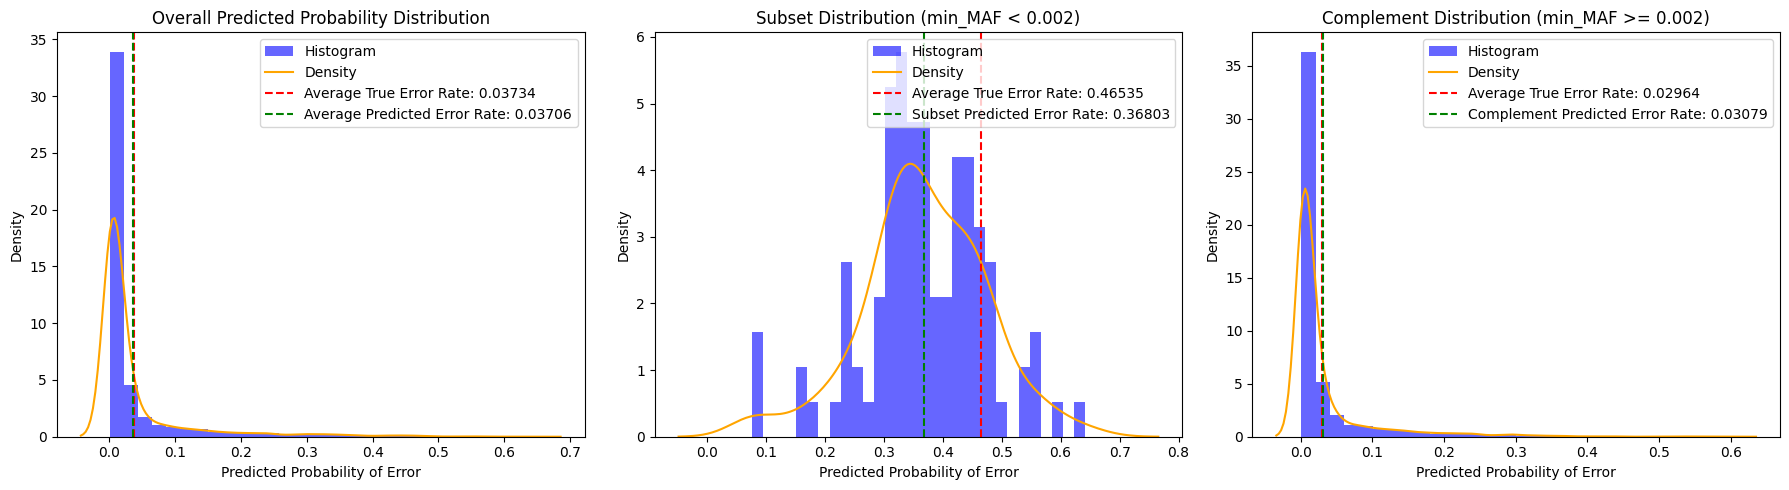

In [141]:
# Assuming 'test_output' is your DataFrame, and the column for predicted probabilities is 'Predicted_prob'
plot_predicted_prob_distribution(test_output, predicted_col='xgb_pred_prob')

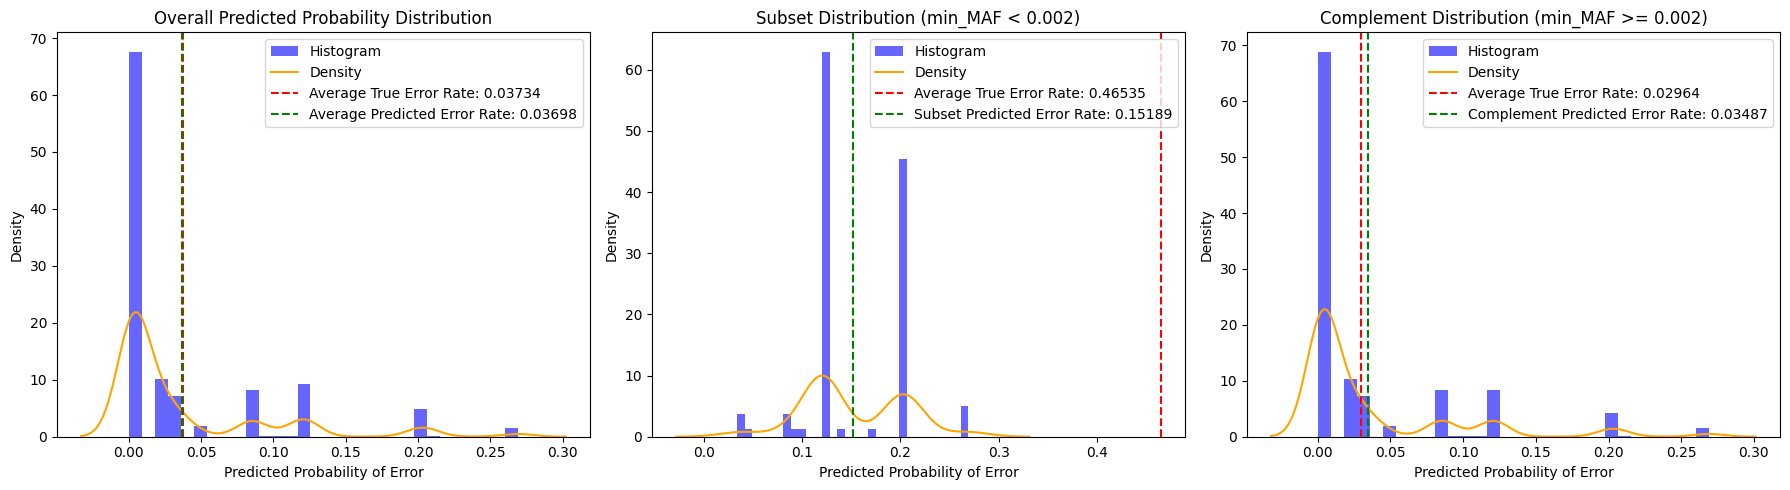

In [143]:
# Assuming 'test_output' is your DataFrame, and the column for predicted probabilities is 'Predicted_prob'
plot_predicted_prob_distribution(test_output, predicted_col='log_pred_prob')

#### visualize the relationship between prediction and features

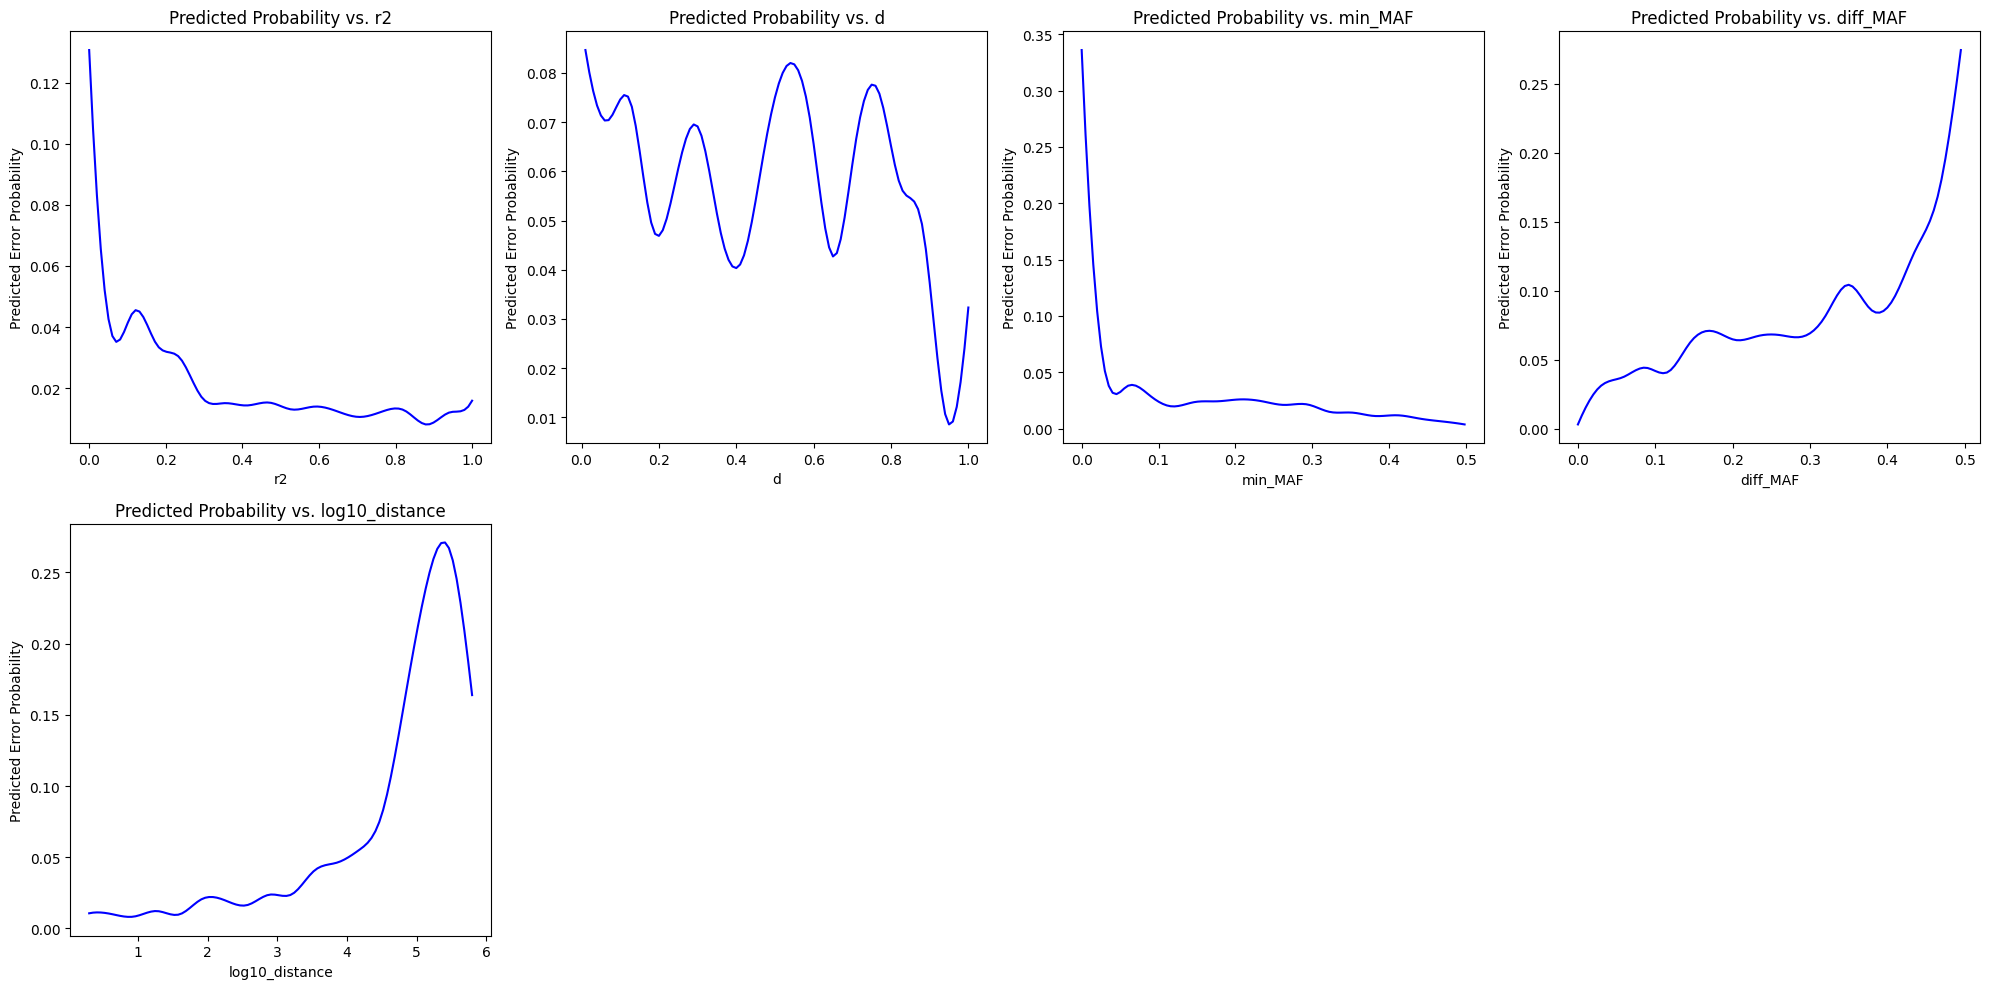

In [151]:
def plot_continuous_predicted_vs_variables(data, variables, row_vars=2):
    """
    Plot scatter plots showing the relationship between continuous predicted probabilities and specified variables.
    
    Args:
    data (DataFrame): The dataset containing the features and continuous predicted probabilities.
    variables (list): List of variable names to plot against predicted probabilities.
    row_vars (int): Number of plots per row.
    """
    # Calculate the number of rows needed based on the number of variables and plots per row
    n_vars = len(variables)
    n_rows = (n_vars + row_vars - 1) // row_vars  # Ensure at least one row if n_vars < row_vars

    # Plotting
    fig, axes = plt.subplots(n_rows, row_vars, figsize=(row_vars * 5, n_rows * 5), squeeze=False)
    for i, var in enumerate(variables):
        ax = axes[i // row_vars, i % row_vars]
        # Scatter plot of the continuous predicted probabilities
        ax.scatter(data[var], data['xgb_pred_prob'], color='blue', alpha=0.5)
        ax.set_title(f'Predicted Probability vs. {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Predicted Error Probability')
        ax.grid(True)

    # Hide unused subplots if the number of variables is not a complete multiple of row_vars
    for j in range(i + 1, n_rows * row_vars):
        if j // row_vars < n_rows and j % row_vars < row_vars:
            axes[j // row_vars, j % row_vars].axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

def plot_smooth_relationship(data, variables, row_vars=2, columnname='xgb_pred_prob'):
    """
    Plot a smooth relationship between predicted probabilities and specified variables using LOESS.
    
    Args:
    data (DataFrame): The dataset containing the features and continuous predicted probabilities.
    variables (list): List of variable names to plot against predicted probabilities.
    row_vars (int): Number of plots per row.
    """
    # Calculate the number of rows needed based on the number of variables and plots per row
    n_vars = len(variables)
    n_rows = (n_vars + row_vars - 1) // row_vars  # Ensure at least one row if n_vars < row_vars

    # Plotting
    fig, axes = plt.subplots(n_rows, row_vars, figsize=(row_vars * 5, n_rows * 5), squeeze=False)
    for i, var in enumerate(variables):
        ax = axes[i // row_vars, i % row_vars]
        # Use Seaborn's lineplot function with a LOESS smoothing approach
        sns.regplot(x=data[var], y=data[columnname], lowess=True, ax=ax, scatter=False, line_kws={"color": "blue"})
        ax.set_title(f'Predicted Probability vs. {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Predicted Error Probability')

    # Hide unused subplots if the number of variables is not a complete multiple of row_vars
    for j in range(i + 1, n_rows * row_vars):
        if j // row_vars < n_rows and j % row_vars < row_vars:
            axes[j // row_vars, j % row_vars].axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

def plot_gam_relationship(data, variables, row_vars=2, columnname='xgb_pred_prob'):
    """
    Plot the relationship between predicted probabilities and specified variables using GAM smoothing.
    
    Args:
    data (DataFrame): The dataset containing the features and continuous predicted probabilities.
    variables (list): List of variable names to plot against predicted probabilities.
    row_vars (int): Number of plots per row.
    """
    n_vars = len(variables)
    n_rows = (n_vars + row_vars - 1) // row_vars  # Ensure at least one row if n_vars < row_vars

    fig, axes = plt.subplots(n_rows, row_vars, figsize=(row_vars * 5, n_rows * 5), squeeze=False)

    for i, var in enumerate(variables):
        ax = axes[i // row_vars, i % row_vars]
        # Fit a GAM model with a smooth term for each variable
        X = data[[var]].values
        y = data[columnname].values
        gam = LinearGAM(s(0)).fit(X, y)
        
        XX = np.linspace(X.min(), X.max(), 100)
        ax.plot(XX, gam.predict(XX), color='blue')
        ax.set_title(f'Predicted Probability vs. {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Predicted Error Probability')

    # Hide unused subplots if necessary
    for j in range(i + 1, n_rows * row_vars):
        axes[j // row_vars, j % row_vars].axis('off')

    plt.tight_layout()
    plt.show()

# Call the GAM function
plot_gam_relationship(test_output, variables, row_vars=4)

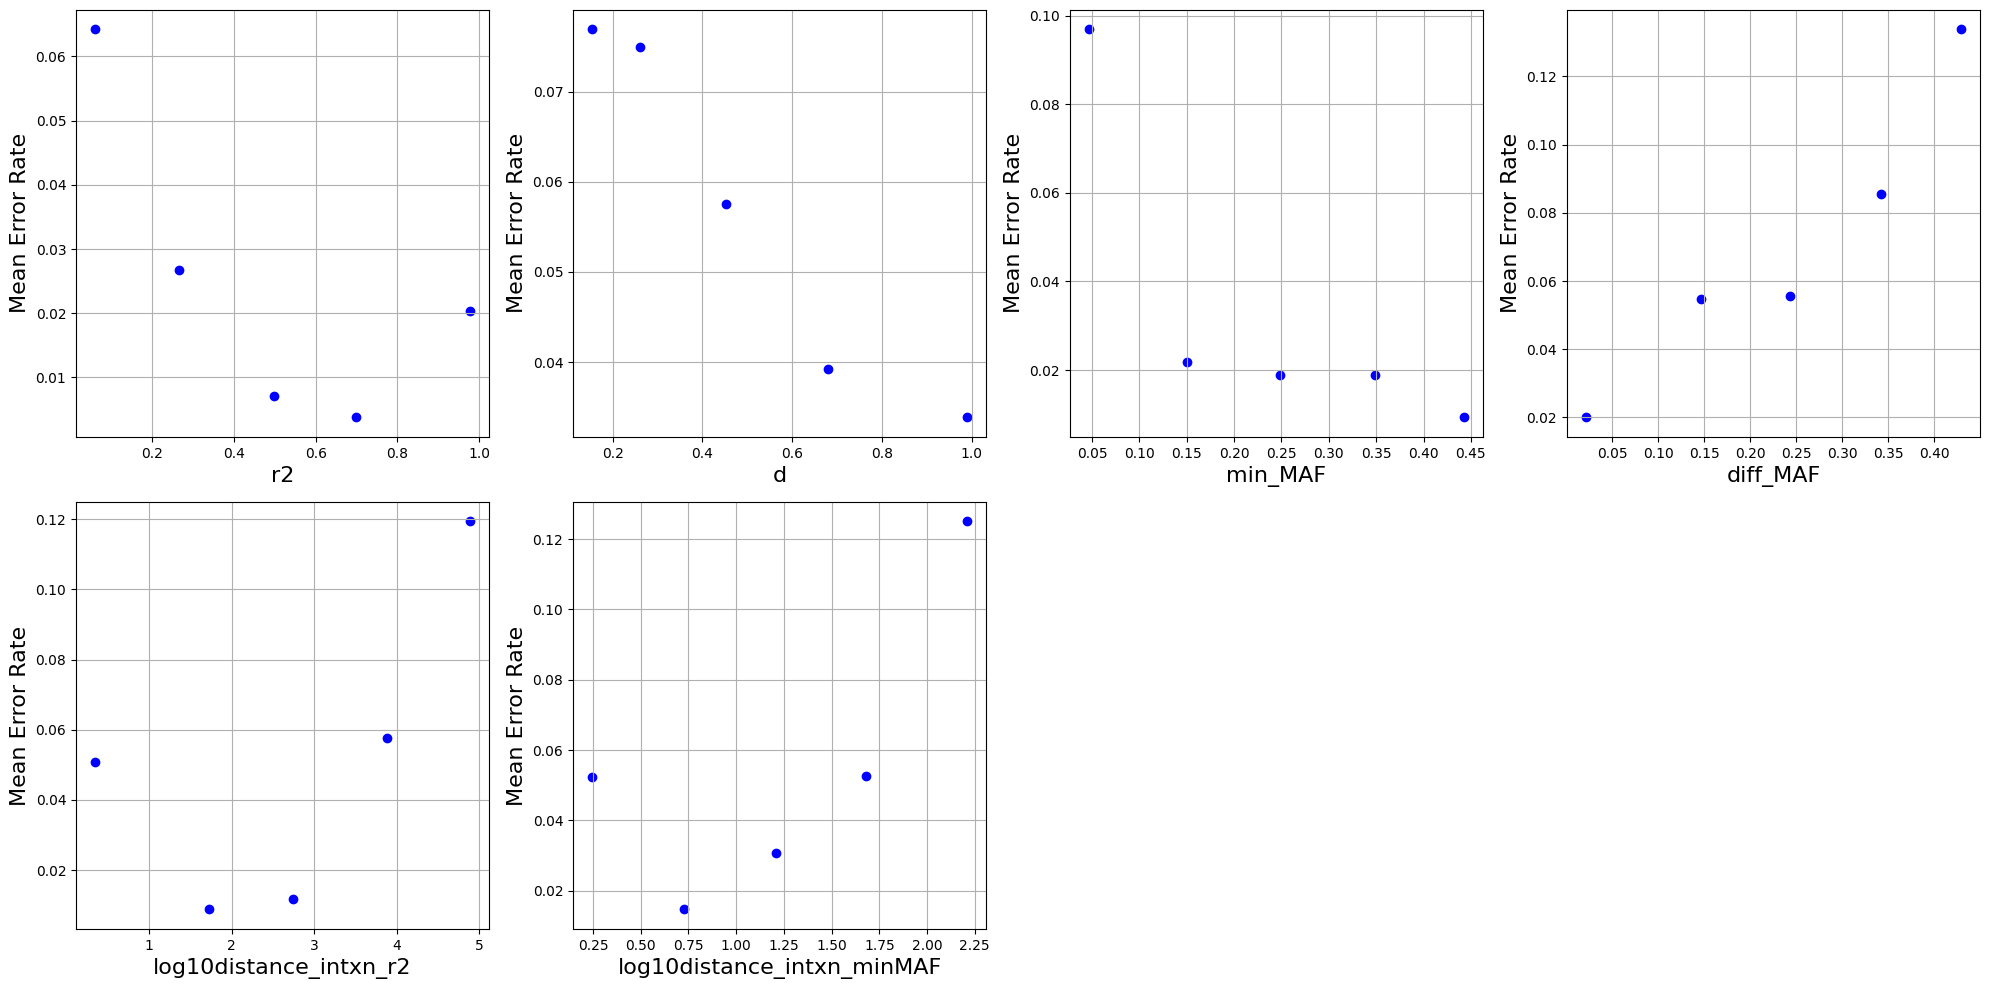

In [130]:
variables = ['r2', 'd','min_MAF', 'diff_MAF','log10distance_intxn_r2','log10distance_intxn_minMAF']

# Call the function with different numbers of plots per row
plot_grid(test_output, variables, bins=5, row_vars=4)

In [368]:
# Call the function with different numbers of plots per row
# plot_continuous_predicted_vs_variables(test_output, variables, row_vars=4)

/home/scarlett/.local/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/scarlett/.local/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


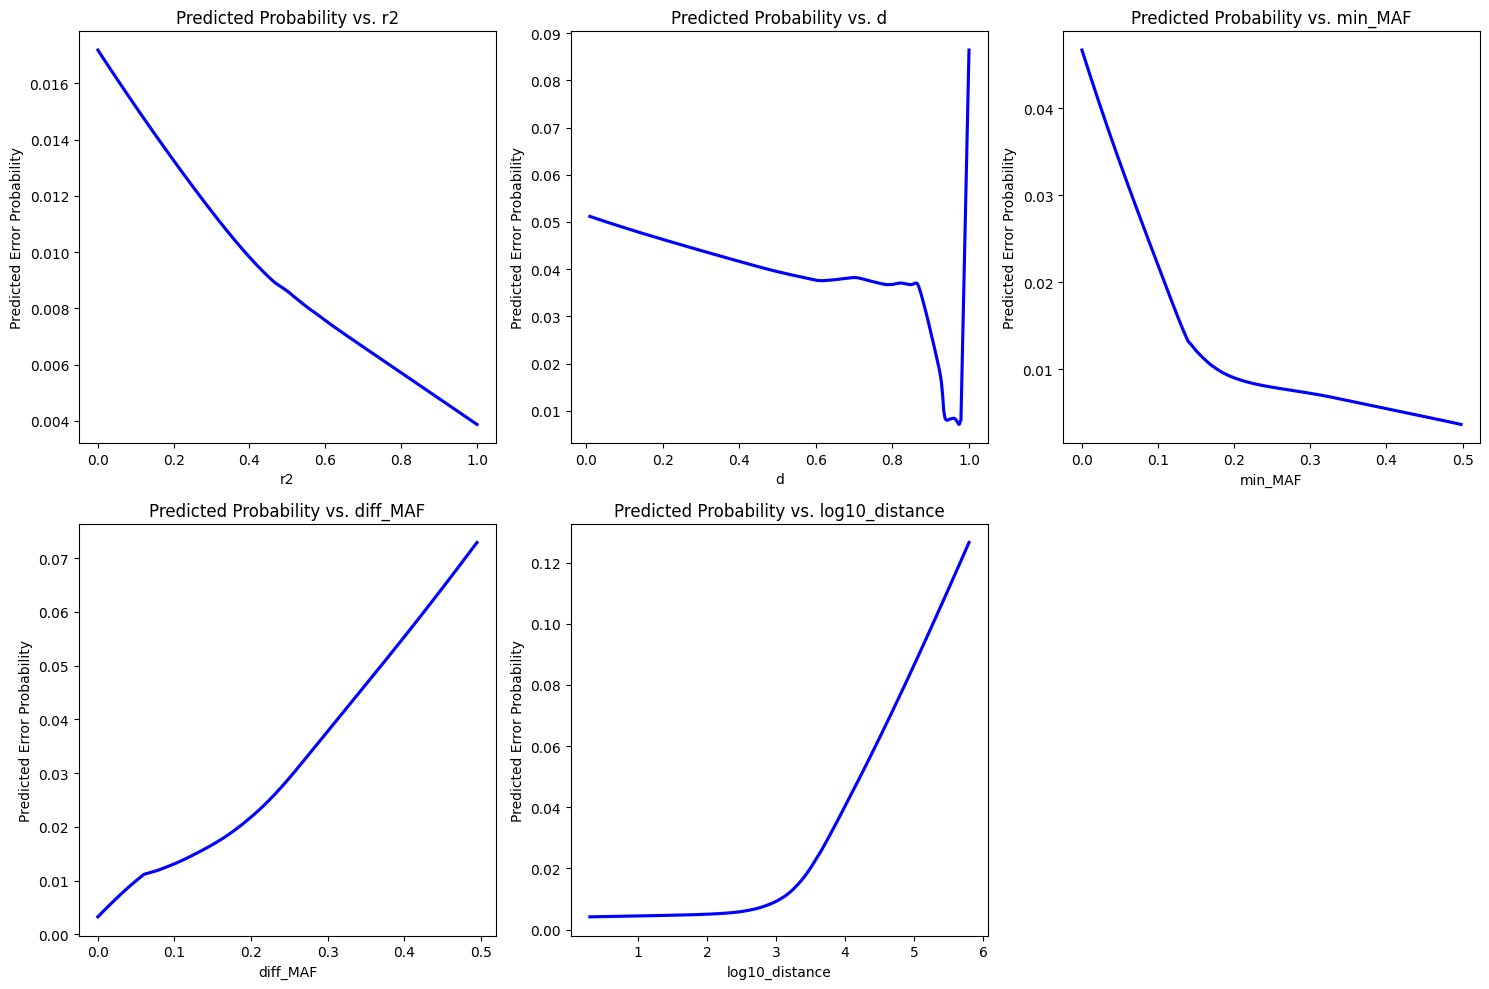

In [152]:
variables = ['r2', 'd','min_MAF', 'diff_MAF','log10_distance']
# Call the function with different numbers of plots per row
plot_smooth_relationship(test_output, variables, row_vars=3,columnname = 'xgb_pred_prob')

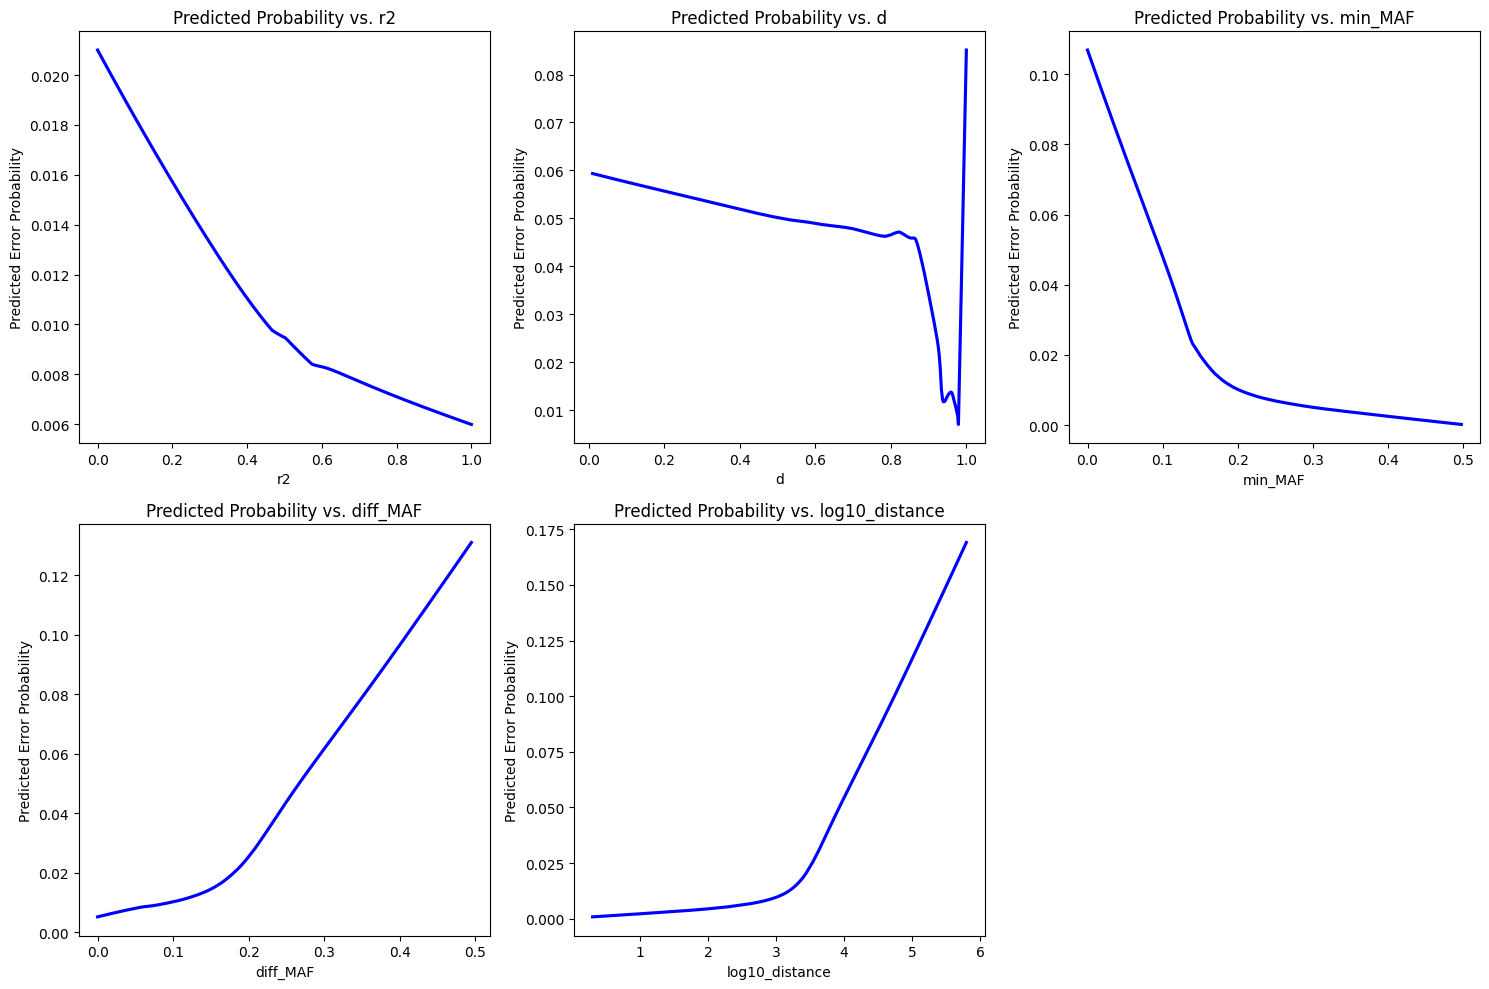

In [153]:
variables = ['r2', 'd','min_MAF', 'diff_MAF','log10_distance']
# Call the function with different numbers of plots per row
plot_smooth_relationship(test_output, variables, row_vars=3,columnname = 'log_pred_prob')

log10_distance:
Trend: The curve shows a strong positive relationship between log10_distance and the predicted error probability. This suggests that as the logarithm of the distance increases, so does the probability of an error, particularly sharply as you move towards higher values.
Interpretation: This might indicate that greater distances (in a logarithmic scale) are associated with increasing uncertainty or error, which could be due to less information or higher variability at greater distances.

r2:
Trend: The curve displays a decreasing trend, indicating that as r2 increases, the predicted error probability decreases.
Interpretation: Typically, r2 is a measure of linkage disequilibrium; higher values might indicate more reliable or stronger genetic associations, leading to lower error probabilities in predictions based on these associations.

min_EUR_MAF:
Trend: This curve also shows a decreasing relationship, suggesting that higher minor allele frequencies are associated with lower error probabilities.
Interpretation: Higher minor allele frequencies could mean more common genetic variations, which might be better understood and more accurately predicted, hence lower errors.

diff_EUR_MAF:
Trend: There's an increasing trend, implying that larger differences in minor allele frequencies lead to higher error probabilities.
Interpretation: A large difference in allele frequencies might indicate genetic heterogeneity or complexity that complicates prediction, leading to higher probabilities of error.

In [134]:
position_ratios = rare_df['position_has_rare_SNP'].tolist()
# rare_prob = test_output[test_output["min_EUR_MAF"] <= 0.002]['Predicted_prob_calibrated'].tolist()
# nonrare_prob = test_output[test_output["min_EUR_MAF"] > 0.002]['Predicted_prob_calibrated'].tolist()
rare_prob = test_output[test_output["min_EUR_MAF"] <= 0.002]['Predicted_prob'].tolist()
nonrare_prob = test_output[test_output["min_EUR_MAF"] > 0.002]['Predicted_prob'].tolist()

KeyError: 'min_EUR_MAF'

In [135]:
position_ratios.__len__()
rare_prob.__len__()
nonrare_prob.__len__()

NameError: name 'rare_prob' is not defined

NameError: name 'rare_prob' is not defined

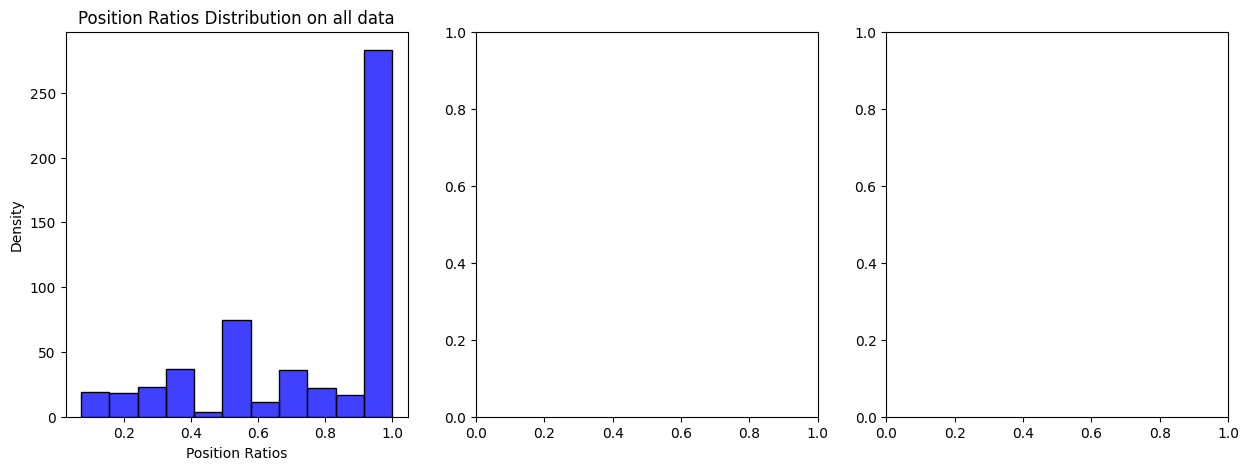

In [133]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting the histogram of 'position_has_rare_SNP'
# Assuming 'result' is your DataFrame with the 'position_has_rare_SNP' column
position_ratios = rare_df['position_has_rare_SNP'].tolist()

# Plot 1: Position Ratios Distribution
sns.histplot(position_ratios, color='blue', ax=axes[0])
axes[0].set_title('Position Ratios Distribution on all data')
axes[0].set_xlabel('Position Ratios')
axes[0].set_ylabel('Density')

# Plot 2: Rare SNP Predicted Probabilities Distribution
sns.histplot(rare_prob, color='green', ax=axes[1])
axes[1].set_title('Rare SNP Probabilities Distribution on Test Data')
axes[1].set_xlabel('Rare SNP Probability')
axes[1].set_ylabel('Density')
axes[1].set_xlim(0, 1)

# Plot 3: Non-Rare SNP Predicted Probabilities Distribution
sns.histplot(nonrare_prob, color='red', ax=axes[2])
axes[2].set_title('Non-Rare SNP Probabilities Distribution on Test Data')
axes[2].set_xlabel('Non-Rare SNP Probability')
axes[2].set_ylabel('Density')
axes[2].set_xlim(0, 1)

# Adjust layout
plt.tight_layout()
plt.show()

### TO DO
- bootstrap for position ratios
- fit beta for rare SNP prob

In [458]:
def simulate_genes(num_genes, num_hets, coverage, position_ratios, 
                   rare_snp_prob_dist, non_rare_snp_prob_dist, binomial_p):
    # Output will store the results for all genes
    output = []
    
    # Iterate through each gene
    for gene_id in range(1, num_genes + 1):
        gene_name = f"gene{gene_id}"  # Set geneID as gene1, gene2, ..., geneN
        gene_output = [gene_name, num_hets]  # Start with geneID and number of hets for each row
        
        # Pick a position ratio to decide which position has the rare SNP
        position_ratio = random.choice(position_ratios)
        rare_snp_position = ceil(position_ratio * num_hets)  # Calculate the position for the rare SNP using ceil
        
        # Simulate REF and ALT reads for each het using binomial distribution
        for het_num in range(1, num_hets + 1):
            alt_reads = np.random.binomial(coverage, binomial_p)
            ref_reads = coverage - alt_reads
            gene_output.extend([ref_reads, alt_reads])  # Add REF and ALT to the output
            
        # Assign error probabilities for each SNP pair
        for het_num in range(1, num_hets):
            if het_num == rare_snp_position:
                error_prob = random.choice(rare_snp_prob_dist)  # Assign rare SNP probability
                #error_prob = 1
            else:
                error_prob = random.choice(non_rare_snp_prob_dist)  # Assign non-rare SNP probability
            gene_output.append(f"{error_prob:.4f}")
        
        # Join the output for the current gene and append to the list
        output.append(" ".join(map(str, gene_output)))
    
    return output

In [459]:
# Simulate the data (example: 100 genes, 10 hets per gene, 100 coverage per het, binomial p=0.5)
num_genes = 10
num_hets = 10
coverage = 100
binomial_p = 0.5  # Input binomial probability

simulated_data = simulate_genes(num_genes=num_genes, 
                                num_hets=num_hets, 
                                coverage=coverage, 
                                position_ratios=position_ratios, 
                                rare_snp_prob_dist=rare_prob, 
                                non_rare_snp_prob_dist=nonrare_prob,
                                binomial_p=binomial_p)

# Print the output
for line in simulated_data:
    print(line)



gene1 10 42 58 53 47 50 50 42 58 52 48 58 42 45 55 56 44 45 55 49 51 0.0064 0.0001 0.0017 0.0118 0.0039 0.0076 0.0014 0.0015 0.0002
gene2 10 57 43 46 54 54 46 51 49 58 42 50 50 56 44 48 52 50 50 59 41 0.0001 0.0146 0.0008 0.3798 0.0289 0.0894 0.0012 0.0002 0.0011
gene3 10 49 51 49 51 47 53 42 58 44 56 55 45 55 45 46 54 48 52 48 52 0.0001 0.0004 0.0008 0.0005 0.0000 0.0018 0.2364 0.0004 0.0345
gene4 10 47 53 52 48 55 45 53 47 51 49 48 52 50 50 54 46 46 54 50 50 0.0344 0.0194 0.0009 0.0029 0.0035 0.0113 0.0077 0.0005 0.0003
gene5 10 54 46 55 45 47 53 56 44 56 44 52 48 55 45 52 48 55 45 40 60 0.0177 0.4052 0.0008 0.0060 0.0041 0.0001 0.0007 0.0742 0.0206
gene6 10 49 51 50 50 51 49 53 47 46 54 47 53 37 63 41 59 48 52 38 62 0.0163 0.0025 0.0000 0.0012 0.0084 0.1133 0.0079 0.4874 0.0115
gene7 10 49 51 44 56 49 51 52 48 53 47 54 46 60 40 50 50 52 48 50 50 0.0110 0.0029 0.0042 0.0000 0.0196 0.0002 0.0007 0.0194 0.0000
gene8 10 52 48 53 47 49 51 40 60 49 51 49 51 58 42 45 55 60 40 39 61 0.0003 

### simulation

In [ ]:
def gen_simulate_semiempirical_genes(
    N,
    M,
    theta,
    read_depth,
    position_ratios, 
    rare_snp_prob_dist, 
    non_rare_snp_prob_dist,
    if_test=False,
):

    p0 = theta / (1 + theta)
    D = read_depth
    # N: number of genes
    for k in tqdm(range(1, N + 1), disable=None):
        if if_test is True:
            print("%% %s th gene" % (k))

        # Pick a position ratio to decide which position has the rare SNP
        position_ratio = random.choice(position_ratios)
        rare_snp_position = ceil(position_ratio * num_hets)  # Calculate the position for the rare SNP using ceil

        # Simulate REF and ALT reads for each het using binomial distribution
        for het_num in range(1, num_hets + 1):
            alt_reads = np.random.binomial(coverage, binomial_p)
            ref_reads = coverage - alt_reads
            gene_output.extend([ref_reads, alt_reads])  # Add REF and ALT to the output

        # Assign error probabilities for each SNP pair
        for het_num in range(1, num_hets):
            if het_num == rare_snp_position:
                error_prob = random.choice(rare_snp_prob_dist)  # Assign rare SNP probability
                #error_prob = 1
            else:
                error_prob = random.choice(non_rare_snp_prob_dist)  # Assign non-rare SNP probability
            gene_output.append(f"{error_prob:.4f}")
        
        # Join the output for the current gene and append to the list
        output.append(" ".join(map(str, gene_output)))
        
        A0s = np.random.binomial(D, p0, size=M)

        ###########################################
        switch_ind = False
        AR_control = []
        debug_switch_ind_list = []
        for j in range(1, M + 1):
            A0 = A0s[j-1]
            R0 = D - A0

            if j > 1:
                if sampled_gene[true_error_column].iloc[j - 1] == 1:
                    switch_ind = not switch_ind

            if switch_ind:
                A0, R0 = R0, A0
            
            AR_control.append(f"{A0}\t{R0}")
            debug_switch_ind_list.append(switch_ind)

        gene = f"gene_{k}"
        PI_pred = '\t'.join(map(str, pred_prob[1:]))

        if if_test is True:
            print(sampled_gene)
            print(PI_pred)
            print(debug_switch_ind_list)

        line = "%s\t%d\t%s\t%s\t%s\n" % (
            gene,
            M,
            "\t".join(AR_control),
            0,
            PI_pred,
        )
        yield line